In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from WindPy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # 导入设置坐标轴的模块
import warnings
import seaborn as sns
from tqdm import tqdm
from itertools import chain
warnings.filterwarnings('ignore')
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use('seaborn')  # plt.style.use('dark_background')
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
# lt = [w.wsd(code, "trade_hiscode,settle", "2015-03-25", "2023-02-01", "",usedf=True)[1]['TRADE_HISCODE'].unique()
#      for code in ['T00.CFE','T01.CFE','T02.CFE']]
# code_dict = pd.DataFrame(lt).T.iloc[:,:2]
# lt = list(set(chain(*lt)))
# lt.sort()
# for code in tqdm(lt):
#     df = w.wsd(code, "PRE_CLOSE,OPEN,HIGH,LOW,CLOSE,VOLUME,AMT,VWAP,PRE_SETTLE,SETTLE,OI,lTDATE_NEW", "2015-03-25", "2023-02-01", "Fill=Previous",usedf=True)[1].dropna()
#     df.to_csv(r'D:\Project\dongfang\TreasuryFutures\input\T\{}.csv'.format(code))


100%|██████████| 33/33 [00:13<00:00,  2.44it/s]


In [114]:
# for each in Path('./input/quote/').resolve().glob('*.csv'):
#     print(each)
def _group_plot(
        df: pd.DataFrame,
        category_col: str,
        cumret_col: str,
        ymin: float = None,
        ymax: float = None,
        multipleLocatorMaxN: int = None
):
    # y轴为cumret_col， x轴为df.index， 按category_col绘制多条曲线
    categories = df[category_col].unique()
    if len(categories) % 2 == 1:
        nrows = len(categories) // 2 + 1
    else:
        nrows = len(categories) // 2

    fig, axs = plt.subplots(nrows, 2, figsize=(15,4*nrows),dpi=120)
    axs = axs.flatten()
   
    for ith,category in enumerate(categories):
        sns.lineplot(
            x='natural_distance',
            y=cumret_col,
            data=df[df[category_col] == category],
            ax=axs[ith],
            label=category,
            ci=None
        )
        sns.lineplot(
            x='trading_distance',
            y=cumret_col,
            data=df[df[category_col] == category],
            ax=axs[ith],
            label=category,
            ci=None
        )
        axs[ith].invert_xaxis()
        axs[ith].set_title(cumret_col)
        axs[ith].grid(True)
        axs[ith].legend()

    for i in range(len(categories)):
#         if ymin and ymax:
#             axs[i].set_ylim(ymin=ymin, ymax=ymax)
        plt.sca(axs[i])
        plt.xticks(rotation=35)
    if len(categories) % 2 == 1:
        fig.delaxes(axs[-1])
    plt.tight_layout()
    plt.plot()
    
def calendar_effect(dominant_type='oi', price_type='settle', start_date='2019-01-01'):
    # 数据读取
    data_path = './input/T'
    data_dict = {}
    data_path = Path(data_path).absolute()
    for x in data_path.glob("*.csv"):
        temp = pd.read_csv(x, index_col=0)
        temp.index.name = 'date'
        temp.index = pd.to_datetime(temp.index)
        temp = (temp
                .rename(columns=lambda x: x.lower())
                .assign(code=x.stem,
                        ret=lambda x: x['settle'] / x['pre_settle'] - 1
                        )
                .set_index('code', append=True)
                )
        data_dict[x.stem] = temp
    # 合约列表
    contract_list = list(data_dict.keys())
    # 拼接数据
    full_data = pd.concat(data_dict.values(), axis=0)
    # 交易日期
    tradingdays_list = full_data.index.get_level_values('date').unique().to_list()
    tradingdays_list.sort()
    
    if dominant_type != 'date':
        # 按dominant_type换月，例如最大oi
        refer = full_data[dominant_type].unstack()
        contract_each_day = refer.idxmax(axis=1).shift(1).bfill().rename('code')
        contract_change_day = contract_each_day.reset_index().groupby('code').first()['date']
        lt = [w.wsd(code, "trade_hiscode,settle,close", "2015-03-25", "2022-11-15", "",usedf=True)[1]['TRADE_HISCODE'].unique()
             for code in ['T00.CFE','T01.CFE']]
        code_dict = pd.DataFrame(lt).T
        code_dict.columns=['T00.CFE','T01.CFE']
        #'T02.CFE' 按oi换月规则部分T02合约尚未上市
        code_dict.index= contract_change_day
        code_data = code_dict.reindex(tradingdays_list).ffill()
        # code_data为每天对应的主力和次主力合约
    else:
        # 按最后交易日结束后切换合约，通过ltdate_new判断
        full_data['ltdate_new'] = pd.to_datetime(full_data['ltdate_new'])
        code_data = full_data.reset_index().set_index('code')['ltdate_new'].drop_duplicates().to_frame('last_day').reset_index().set_index('last_day').reindex(tradingdays_list).bfill()
        code_data = code_data.fillna(contract_list[contract_list.index(code_data.dropna()['code'][-1])+1])
        next_trade_contract = dict(zip(contract_list[:-1],contract_list[1:]))
        code_data.columns=['T00.CFE']
        code_data['T01.CFE'] = code_data['T00.CFE'].apply(lambda x: next_trade_contract[x])
        code_dict = code_data.reset_index().groupby('T00.CFE')[['last_day']].first()
        code_dict=code_dict.reset_index().set_index('last_day')
    
    # 按code_data得到交易价格序列
    for col in code_data.columns:
        code_data[price_type+'_'+col] = full_data.loc[code_data[col].to_frame('code').reset_index().apply(lambda x:tuple(x), axis=1).values.tolist(), price_type].values.tolist()
    code_data['dif'] = code_data[price_type+'_T00.CFE']-code_data[price_type+'_T01.CFE']
    # tag为切换日期
    code_data['tag'] = 0
    code_data['tag'] = np.where(code_data.index.isin(code_dict.index),1,0)
        # 合上资金利率
    rate = pd.read_csv('./input/BondYield_CCDC.csv',index_col=0, parse_dates=['date'])
    code_data = code_data.merge(rate['yield'],left_index=True, right_index=True, how='left')
    
    if start_date is not None:
        code_data = code_data.loc[start_date:]
        
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
    # 历史基差图
    ax2 = ax1.twinx()
    ax1.yaxis.set_ticks_position('right')
    ax2.yaxis.set_ticks_position('left')
    code_data['dif'].plot(ax=ax1, label='price diff (right)', rot=0, alpha=0.5, fontsize=13, grid=False, color='deepskyblue')
    code_data['yield'].plot(ax=ax2, label='rate yield(left)', rot=0, alpha=0.5, fontsize=13)
    code_data['tag'].plot(ax=ax2, label='Contract change', rot=0, alpha=0.5, fontsize=13,)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1 + h2, l1 + l2, fontsize=15, loc='upper left', ncol=1)
    fig.tight_layout()
    plt.title('histroy basis')
    plt.show()

    # 按年份绘制历史基差
    code_data_year=pd.DataFrame()
    for x in code_data.index.year.unique():
        code_data_year[x]=code_data.assign(date=code_data.index.astype(str).str[5:]).loc[code_data.index.year==x].set_index('date')['dif']
    code_data_year.sort_index(inplace=True)
    code_data_year.ffill().plot(figsize=(15, 6))
    plt.legend()
    fig.tight_layout()
    plt.title('history basis groupby year')
    plt.show()
    
    # 按距离进行统计
    code_data['natural_distance'] = float("nan")
    code_data['trading_distance'] = float("nan")
    for ii in range(len(code_data)):
        try:
            code_data['natural_distance'].iloc[ii] = min([(x-code_data.index[ii]).days for x in code_data[code_data['tag']==1].index if (x-code_data.index[ii]).days>=0])
            code_data['trading_distance'].iloc[ii] = min([(code_data.index.get_loc(x)-ii) for x in code_data[code_data['tag']==1].index if (code_data.index.get_loc(x)-ii)>=0])
        except:
            pass
        
    # 最近五个合约的基差变化图
    code_data_contract=pd.DataFrame()
    code_list = list(code_data['T00.CFE'].unique())
    code_list.sort()
    for x in code_list[-6:-1]:
        code_data_contract[x]=code_data.loc[code_data['T00.CFE']==x].set_index('trading_distance')['dif']
    code_data_contract.sort_index(inplace=True)
    code_data_contract.ffill().plot(figsize=(15, 6))
    plt.gca().invert_xaxis()
    plt.legend()
    fig.tight_layout()
    plt.title('history basis groupby year')
    plt.show()
    
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
    natural_dif = code_data.dropna().groupby('natural_distance')['dif']
    natural_dif.mean()[natural_dif.count()>=5].plot()
    # dif.mean().plot()
    trading_dif = code_data.dropna().groupby('trading_distance')['dif']
    trading_dif.mean()[trading_dif.count()>=5].plot()
    plt.legend(['natural','trading'])
    plt.gca().invert_xaxis()
    plt.title('calendar effect')
    plt.show()
    
    # 季月合约基差曲线
    code_data['month']=code_data['T00.CFE'].str[3:5]
    _group_plot(code_data,'month','dif')
    
    # 各个合约基差曲线
    _group_plot(code_data,'T00.CFE','dif')
    
    return code_data

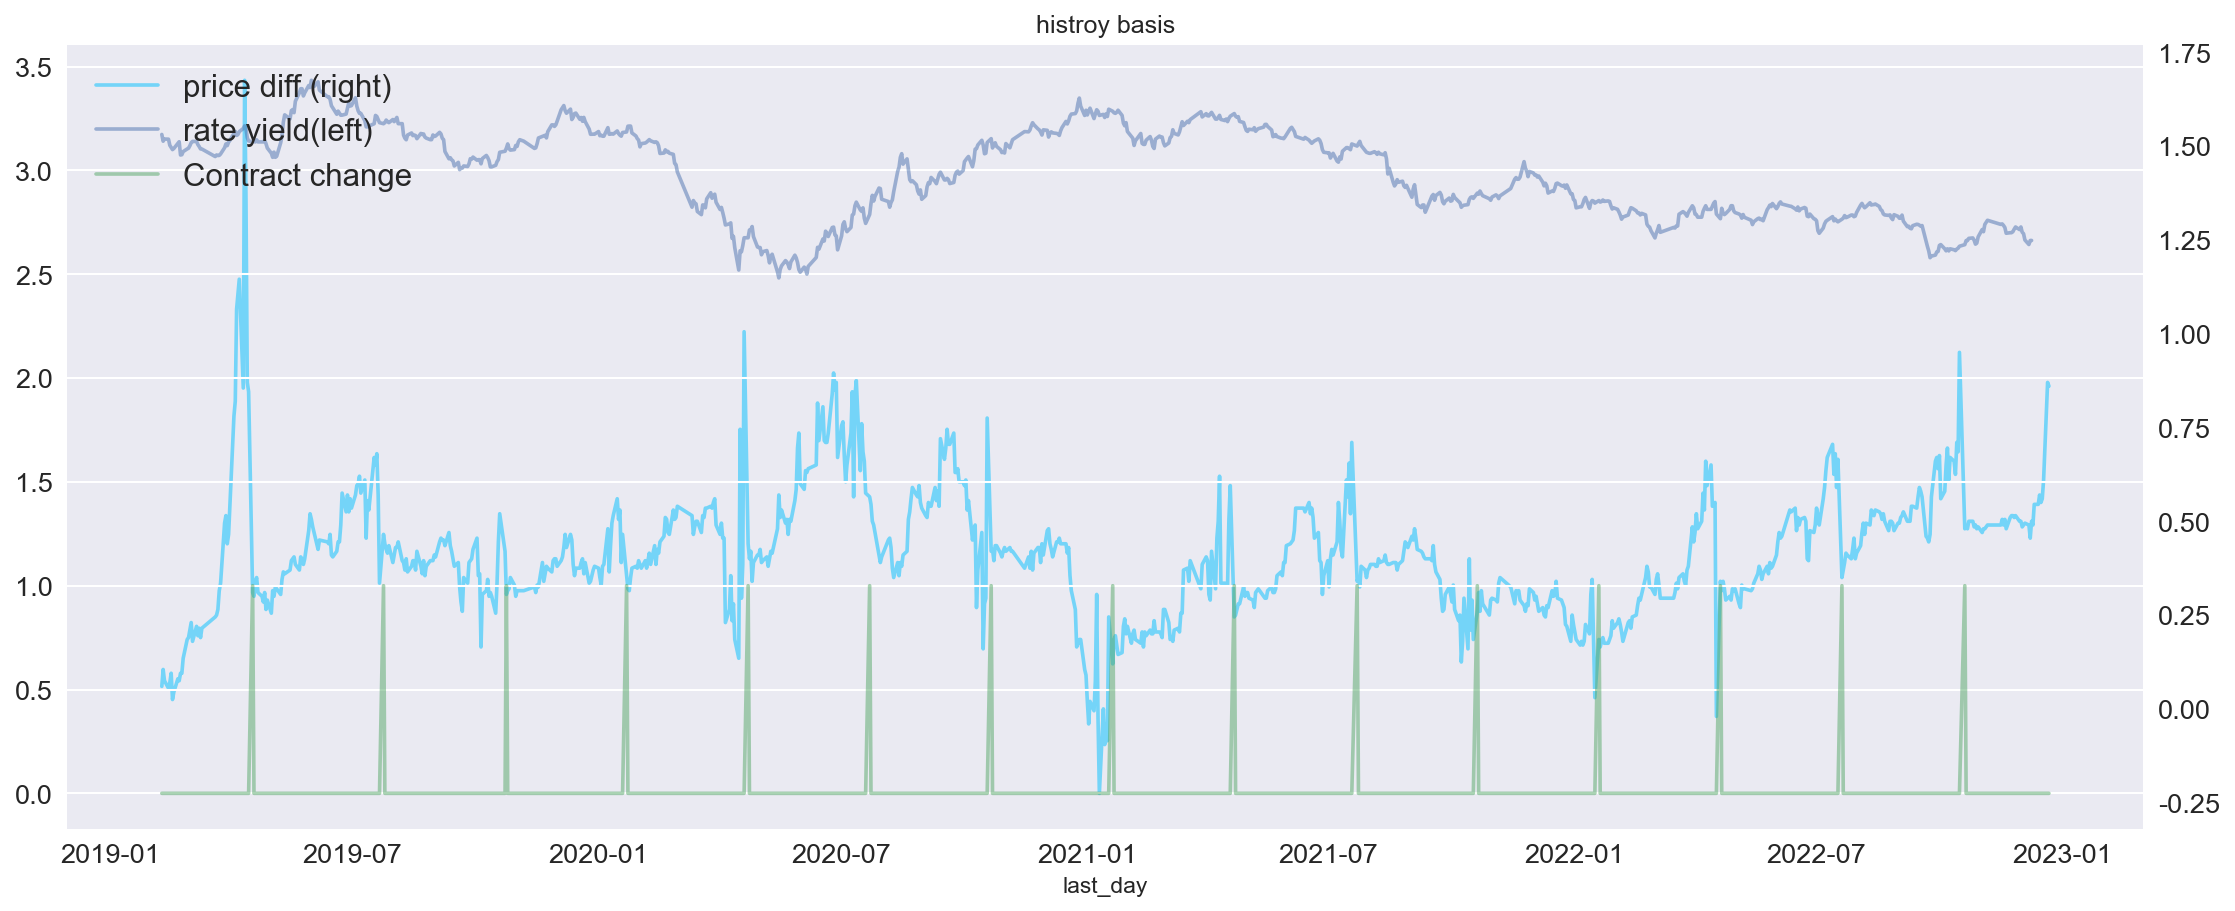

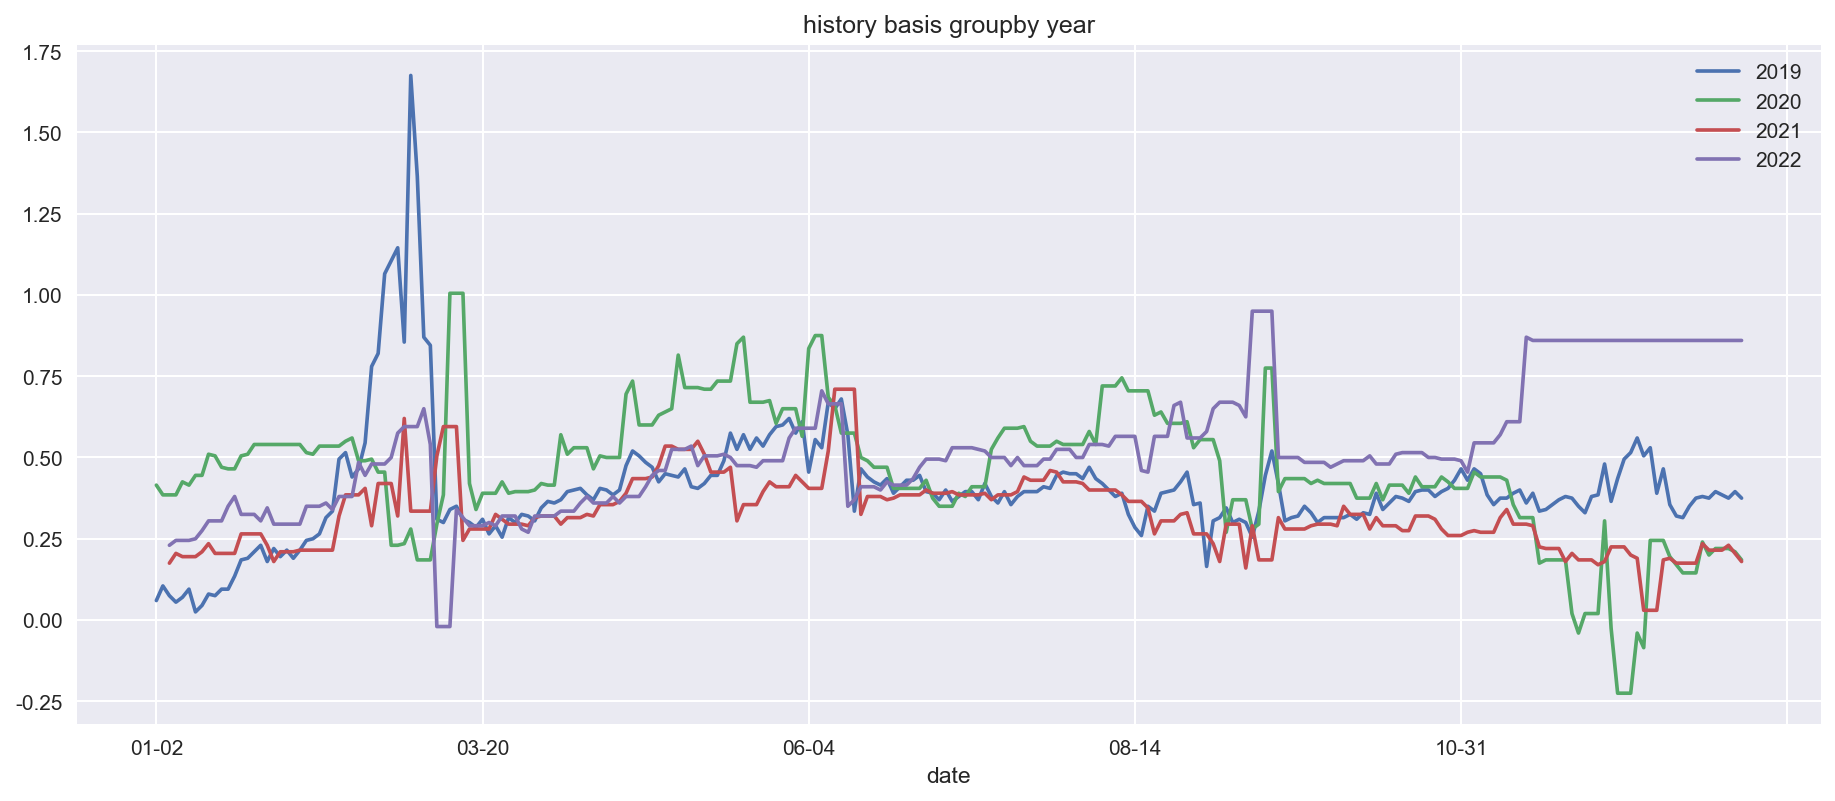

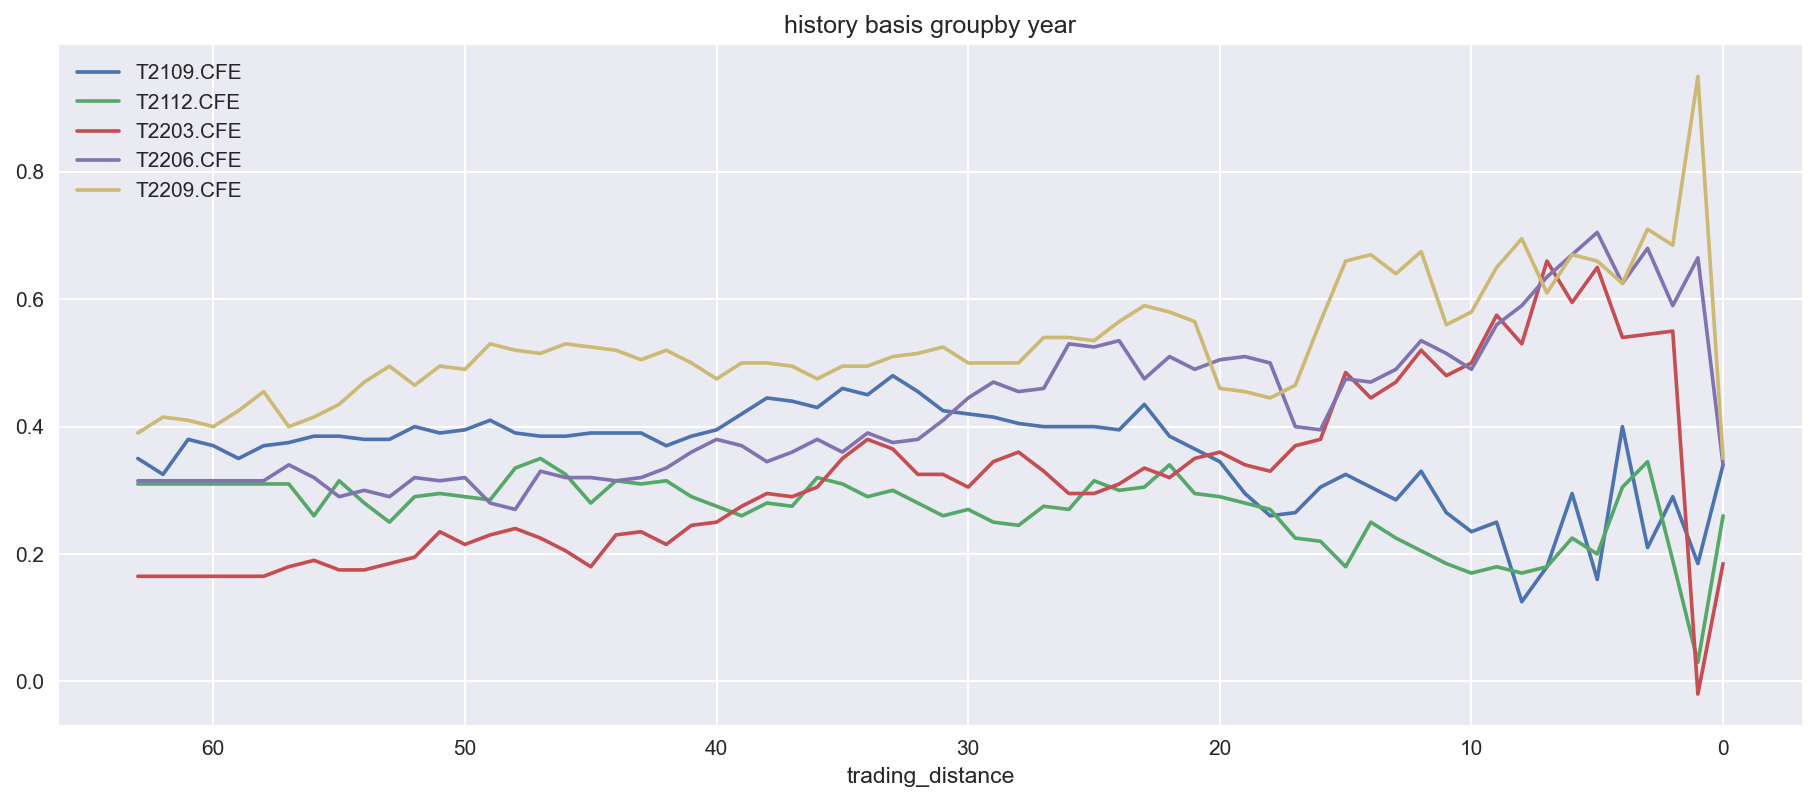

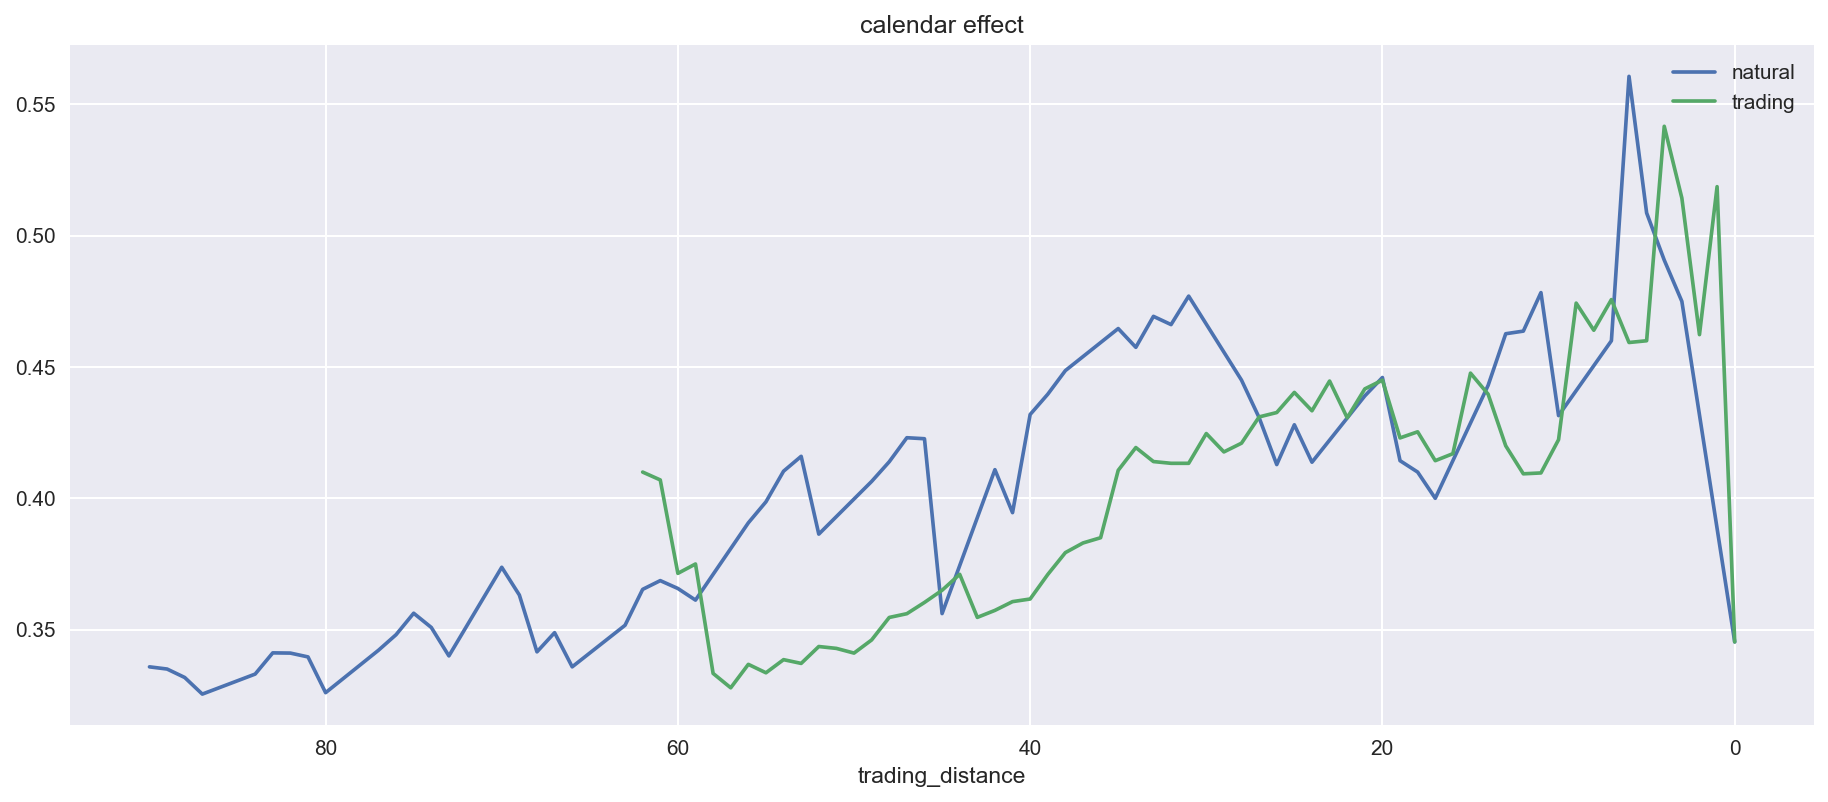

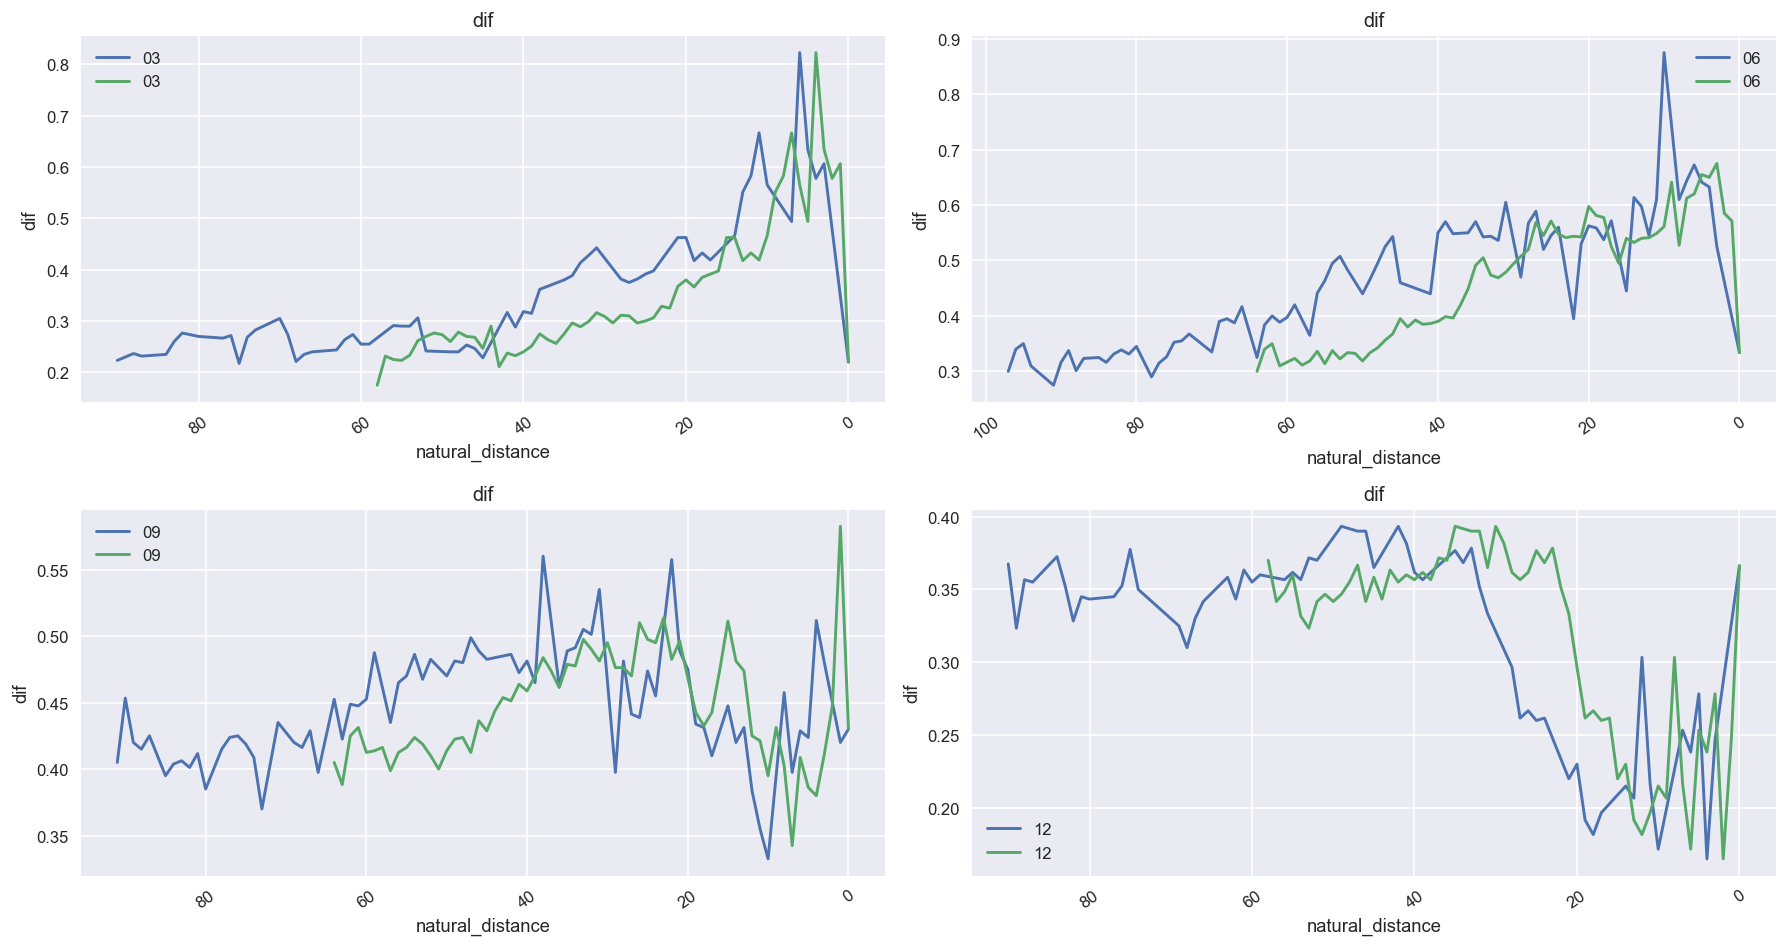

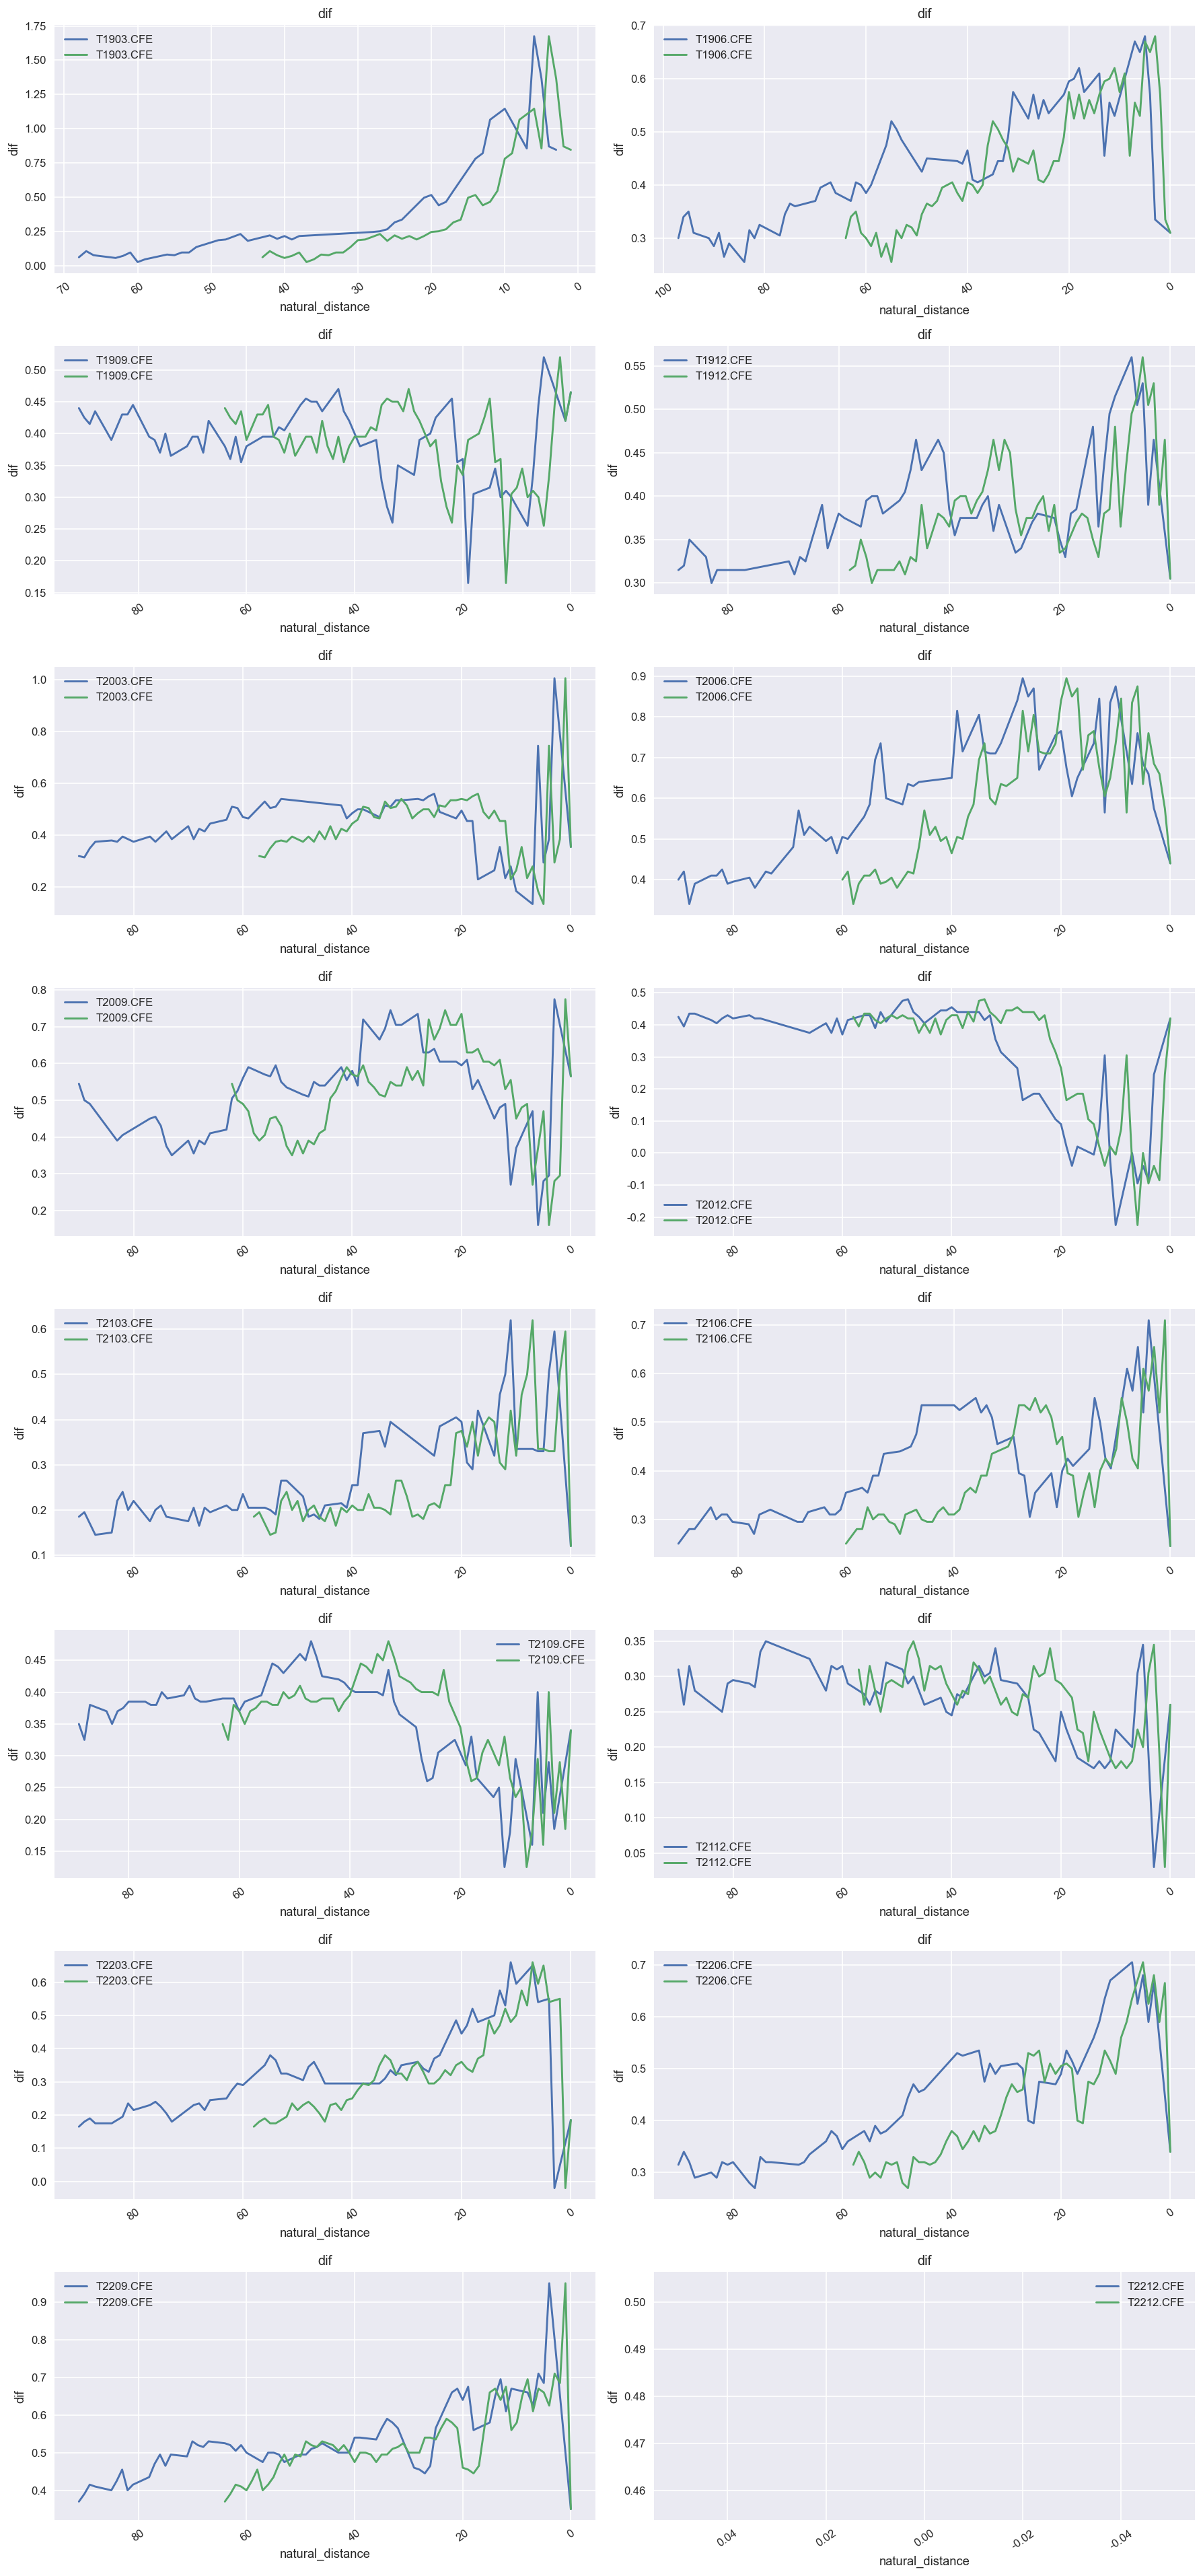

In [115]:
df_date_close = calendar_effect(dominant_type='date',price_type='close')

In [145]:
df_date

T00.CFE    T01.CFE  close_T00.CFE  close_T01.CFE    dif  tag  \
last_day                                                                     
2019-01-02  T1903.CFE  T1906.CFE         98.105         98.045  0.060    0   
2019-01-03  T1903.CFE  T1906.CFE         98.160         98.055  0.105    0   
2019-01-04  T1903.CFE  T1906.CFE         97.945         97.870  0.075    0   
2019-01-07  T1903.CFE  T1906.CFE         97.935         97.880  0.055    0   
2019-01-08  T1903.CFE  T1906.CFE         98.455         98.385  0.070    0   
...               ...        ...            ...            ...    ...  ...   
2022-11-09  T2212.CFE  T2303.CFE        101.530        100.980  0.550    0   
2022-11-10  T2212.CFE  T2303.CFE        101.510        100.950  0.560    0   
2022-11-11  T2212.CFE  T2303.CFE        101.120        100.510  0.610    0   
2022-11-14  T2212.CFE  T2303.CFE        100.425         99.555  0.870    0   
2022-11-15  T2212.CFE  T2303.CFE        100.490         99.630  0.860    0   

            natural_distance  trading_distance month  
last_day                                              
2019-01-02              68.0              43.0    03  
2019-01-03              67.0              42.0    03  
2019-01-04              66.0              41.0    03  
2019-01-07              63.0              40.0    03  
2019-01-08              62.0              39.0    03  
...                      ...               ...   ...  
2022-11-09               NaN               NaN    12  
2022-11-10               NaN               NaN    12  
2022-11-11               NaN               NaN    12  
2022-11-14               NaN               NaN    12  
2022-11-15               NaN               NaN    12  

[939 rows x 9 columns]

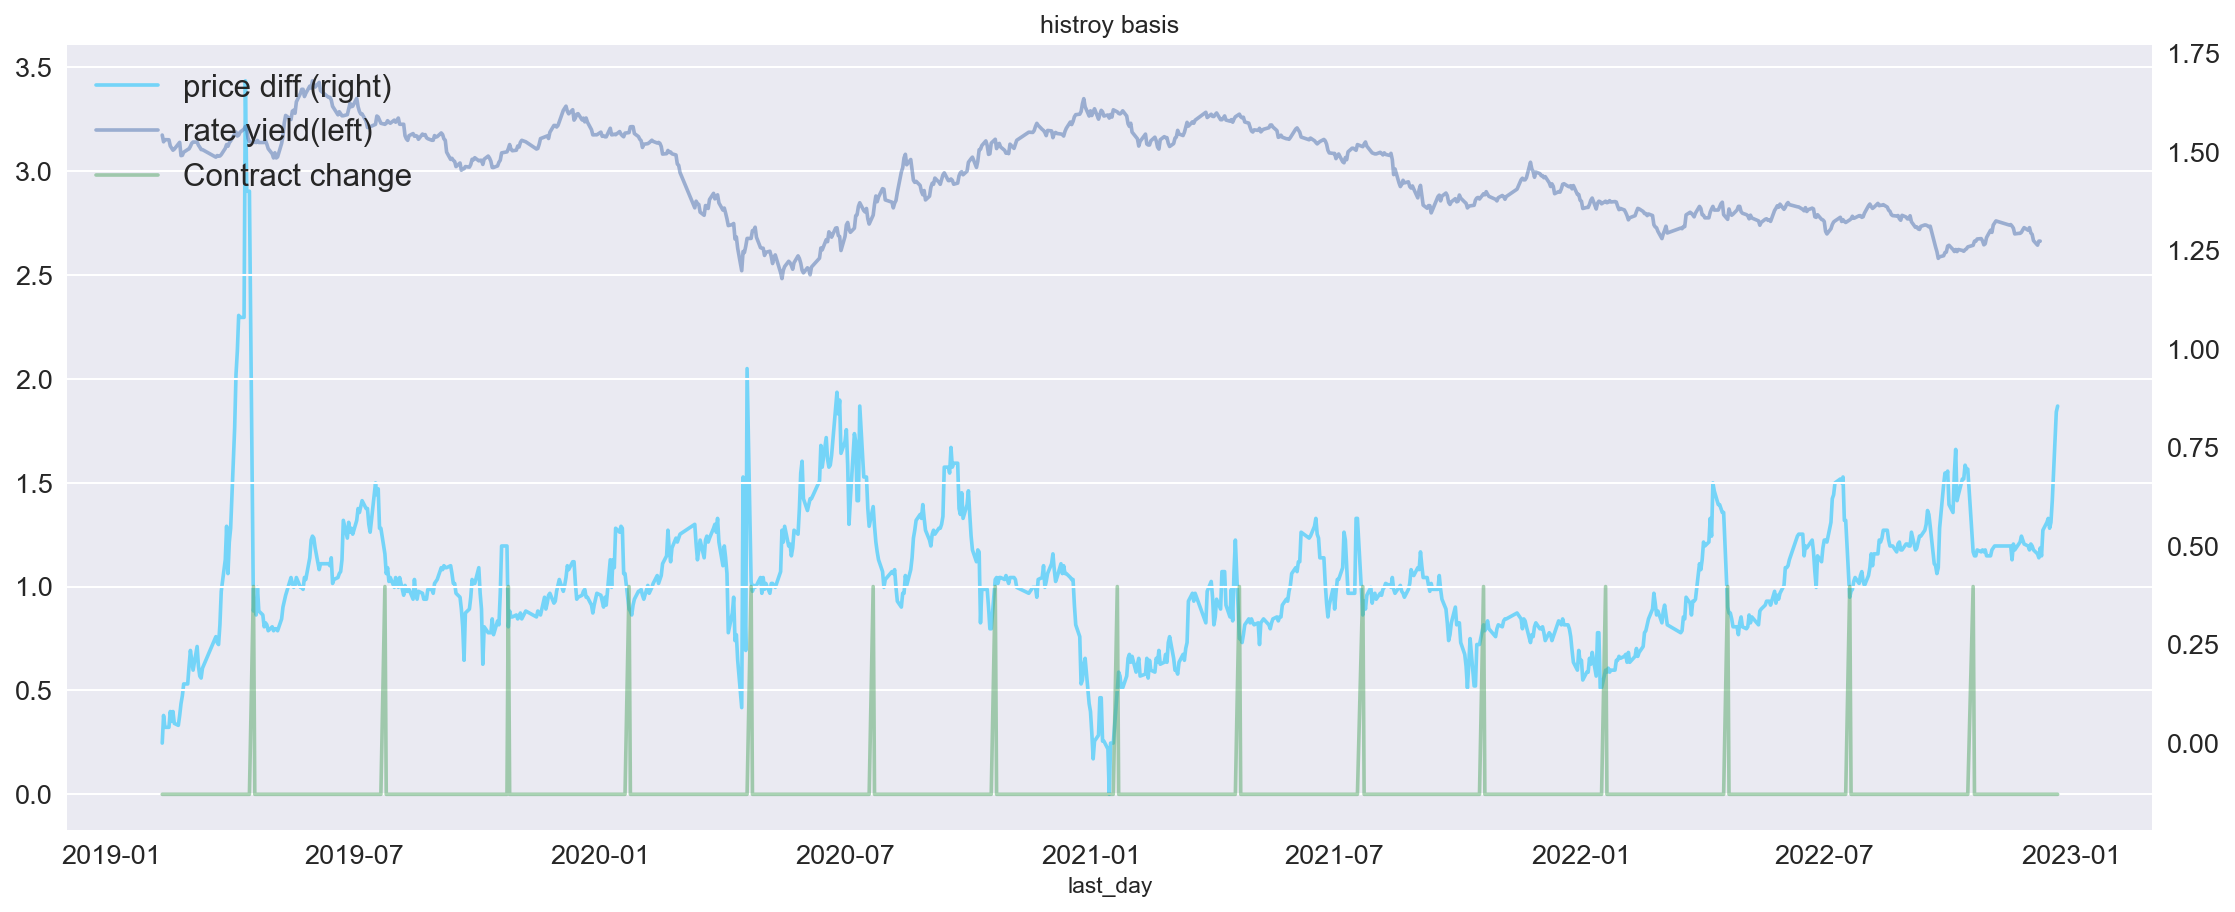

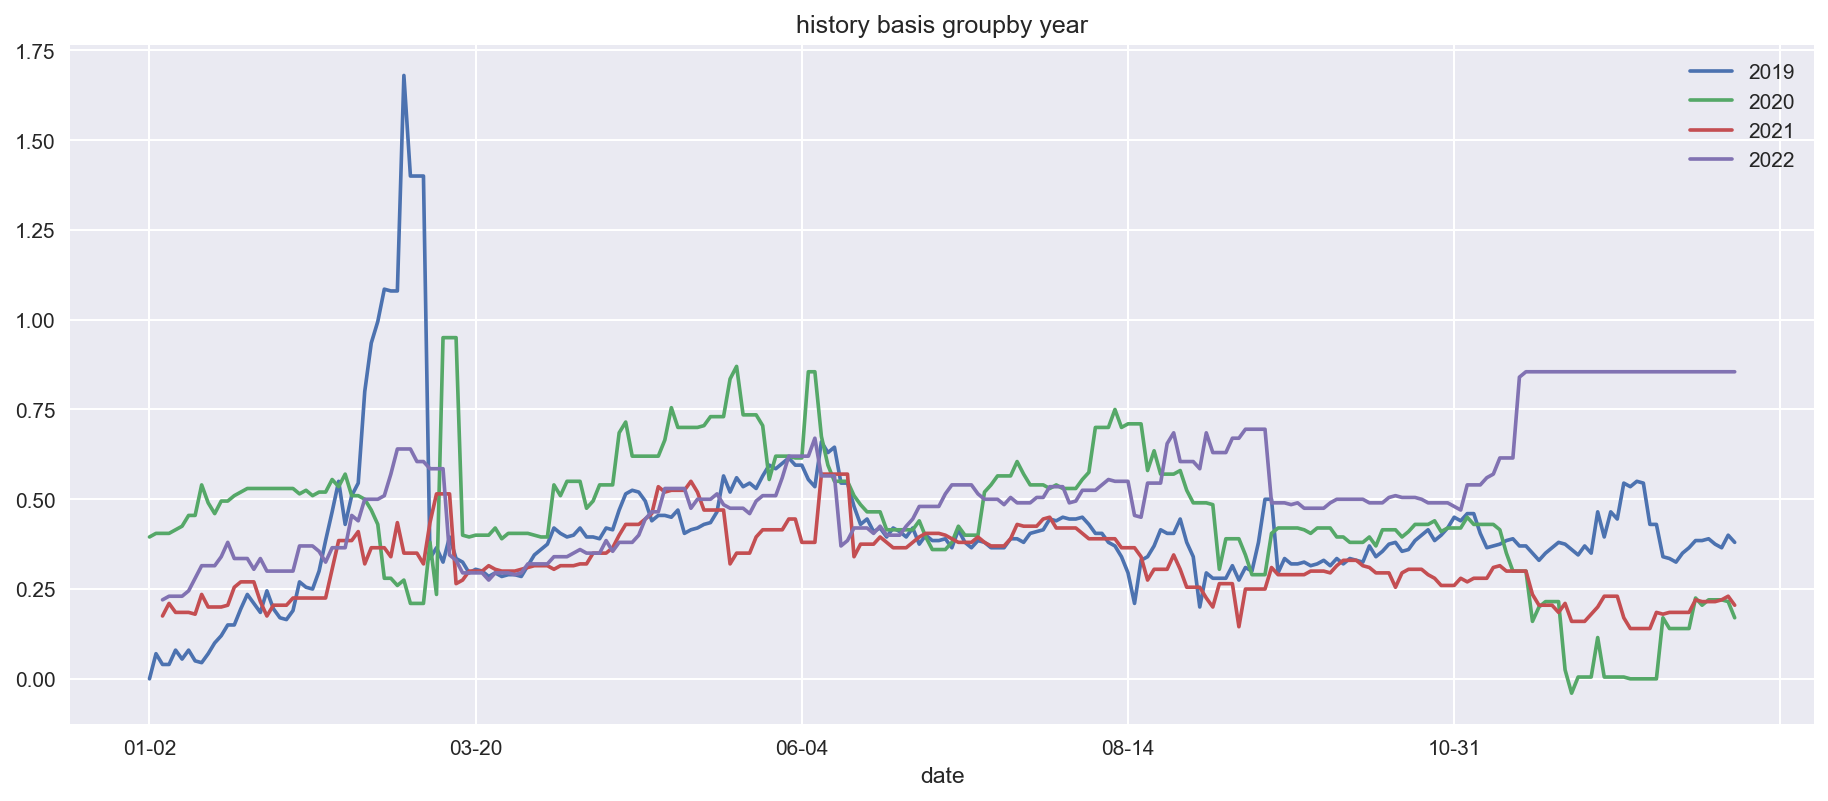

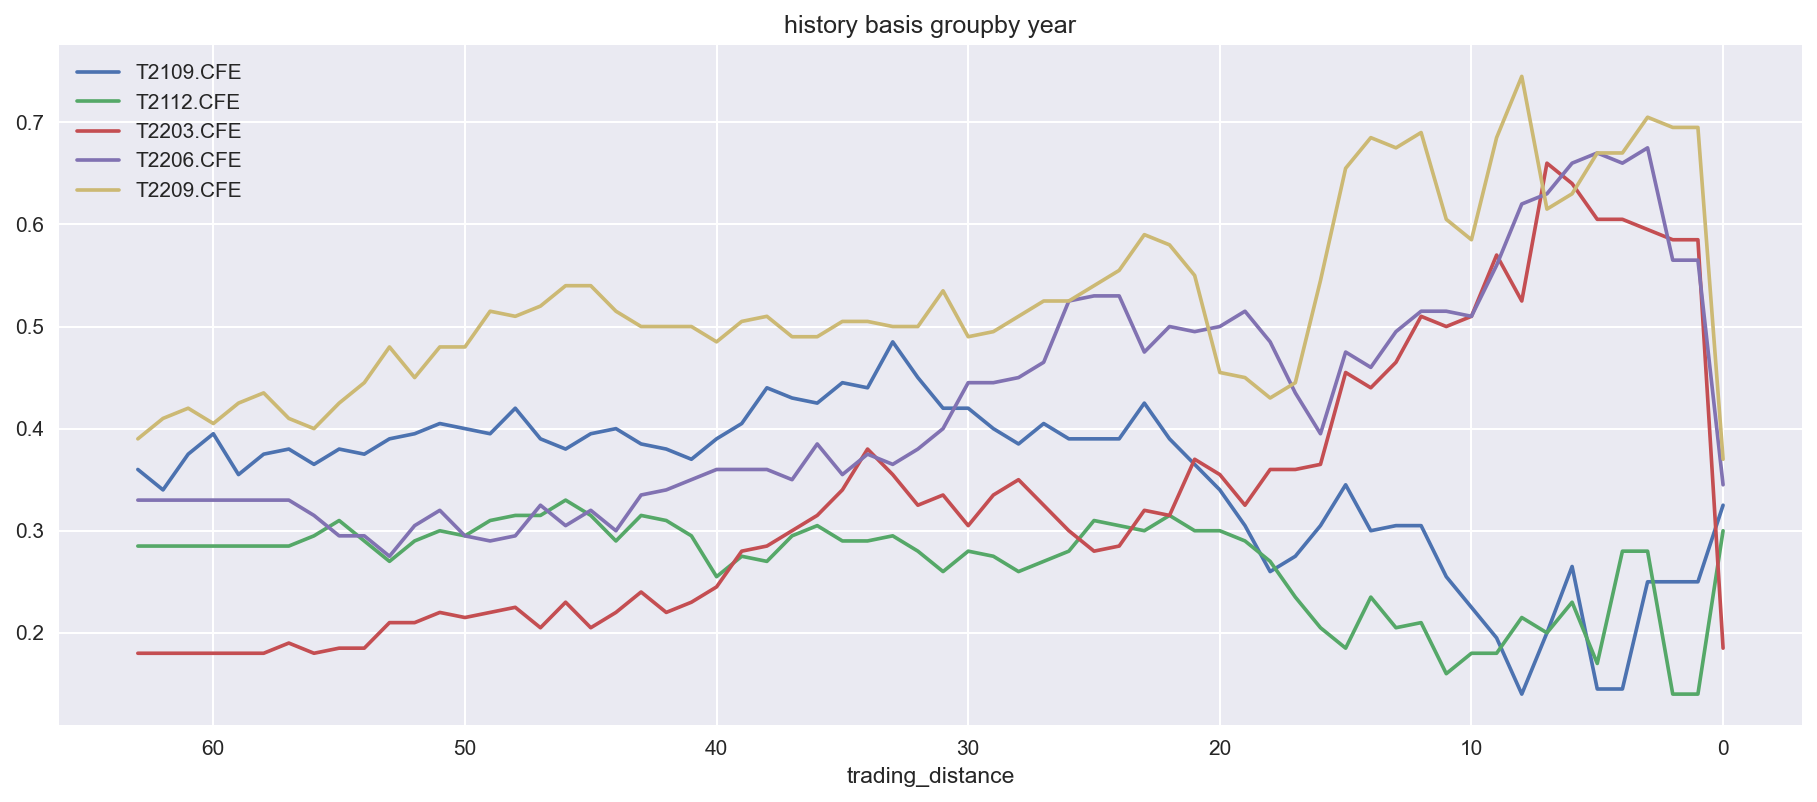

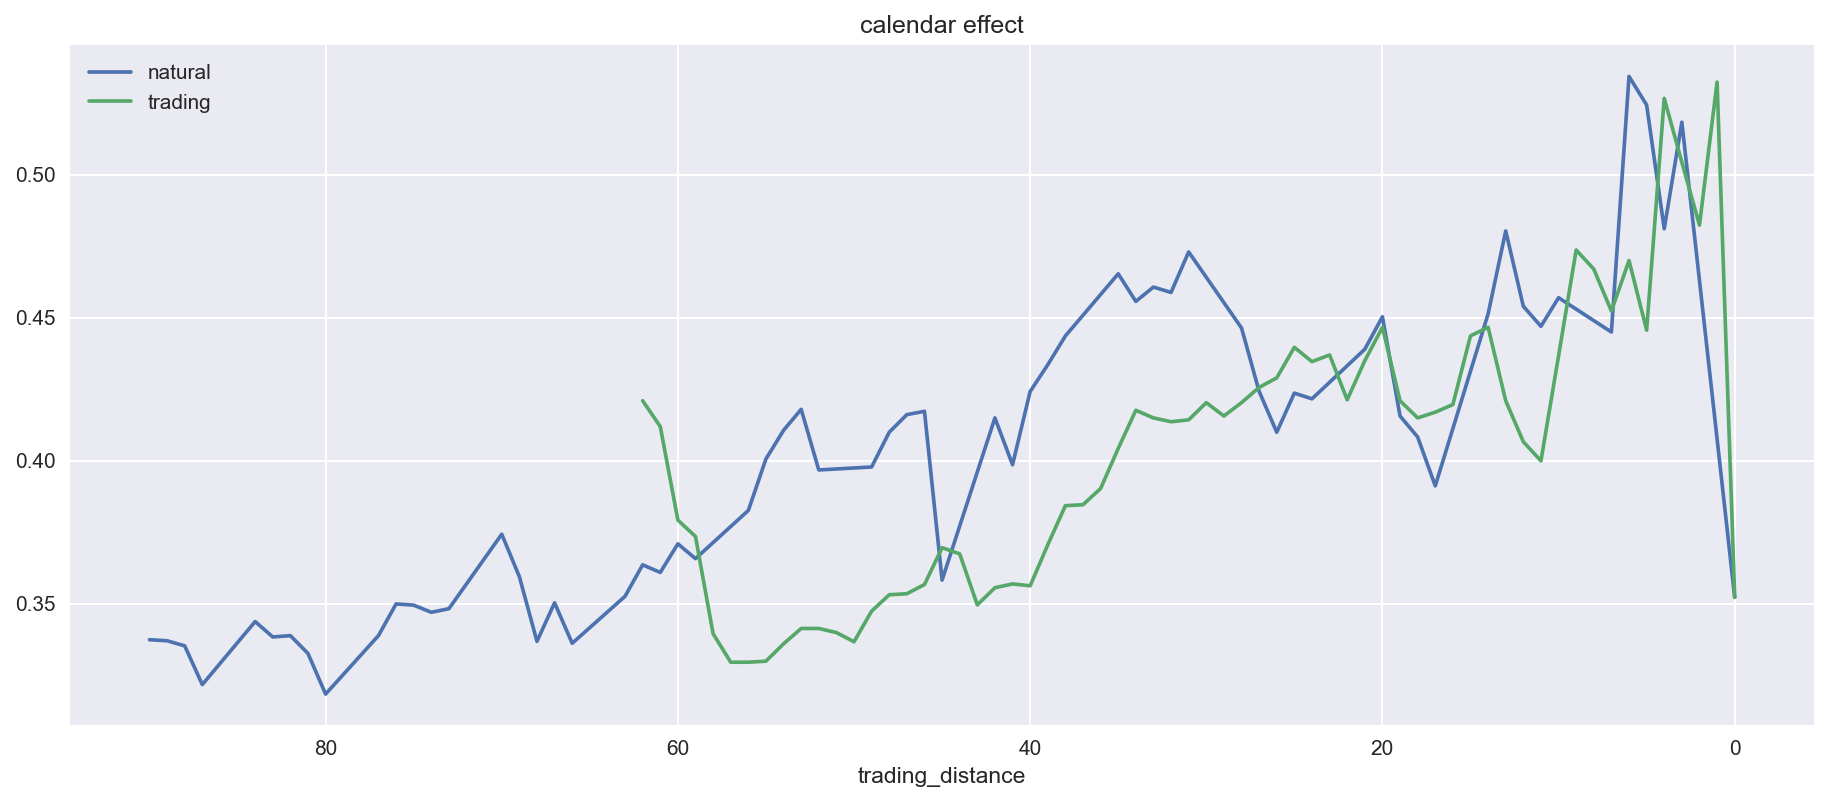

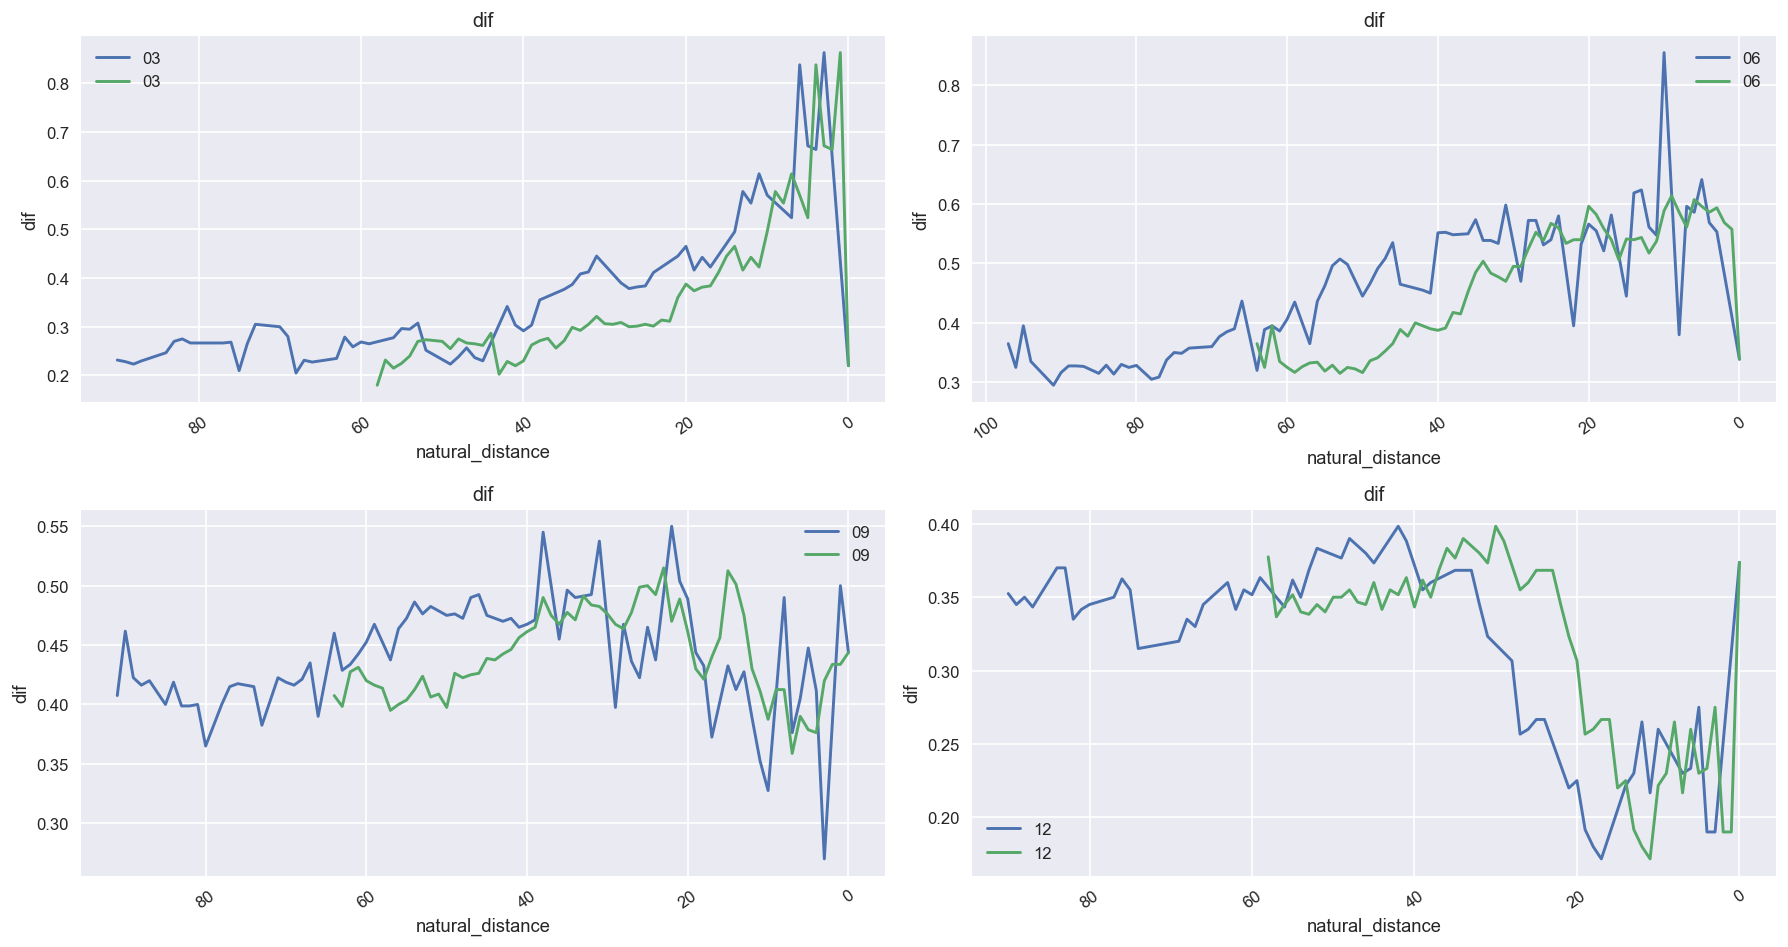

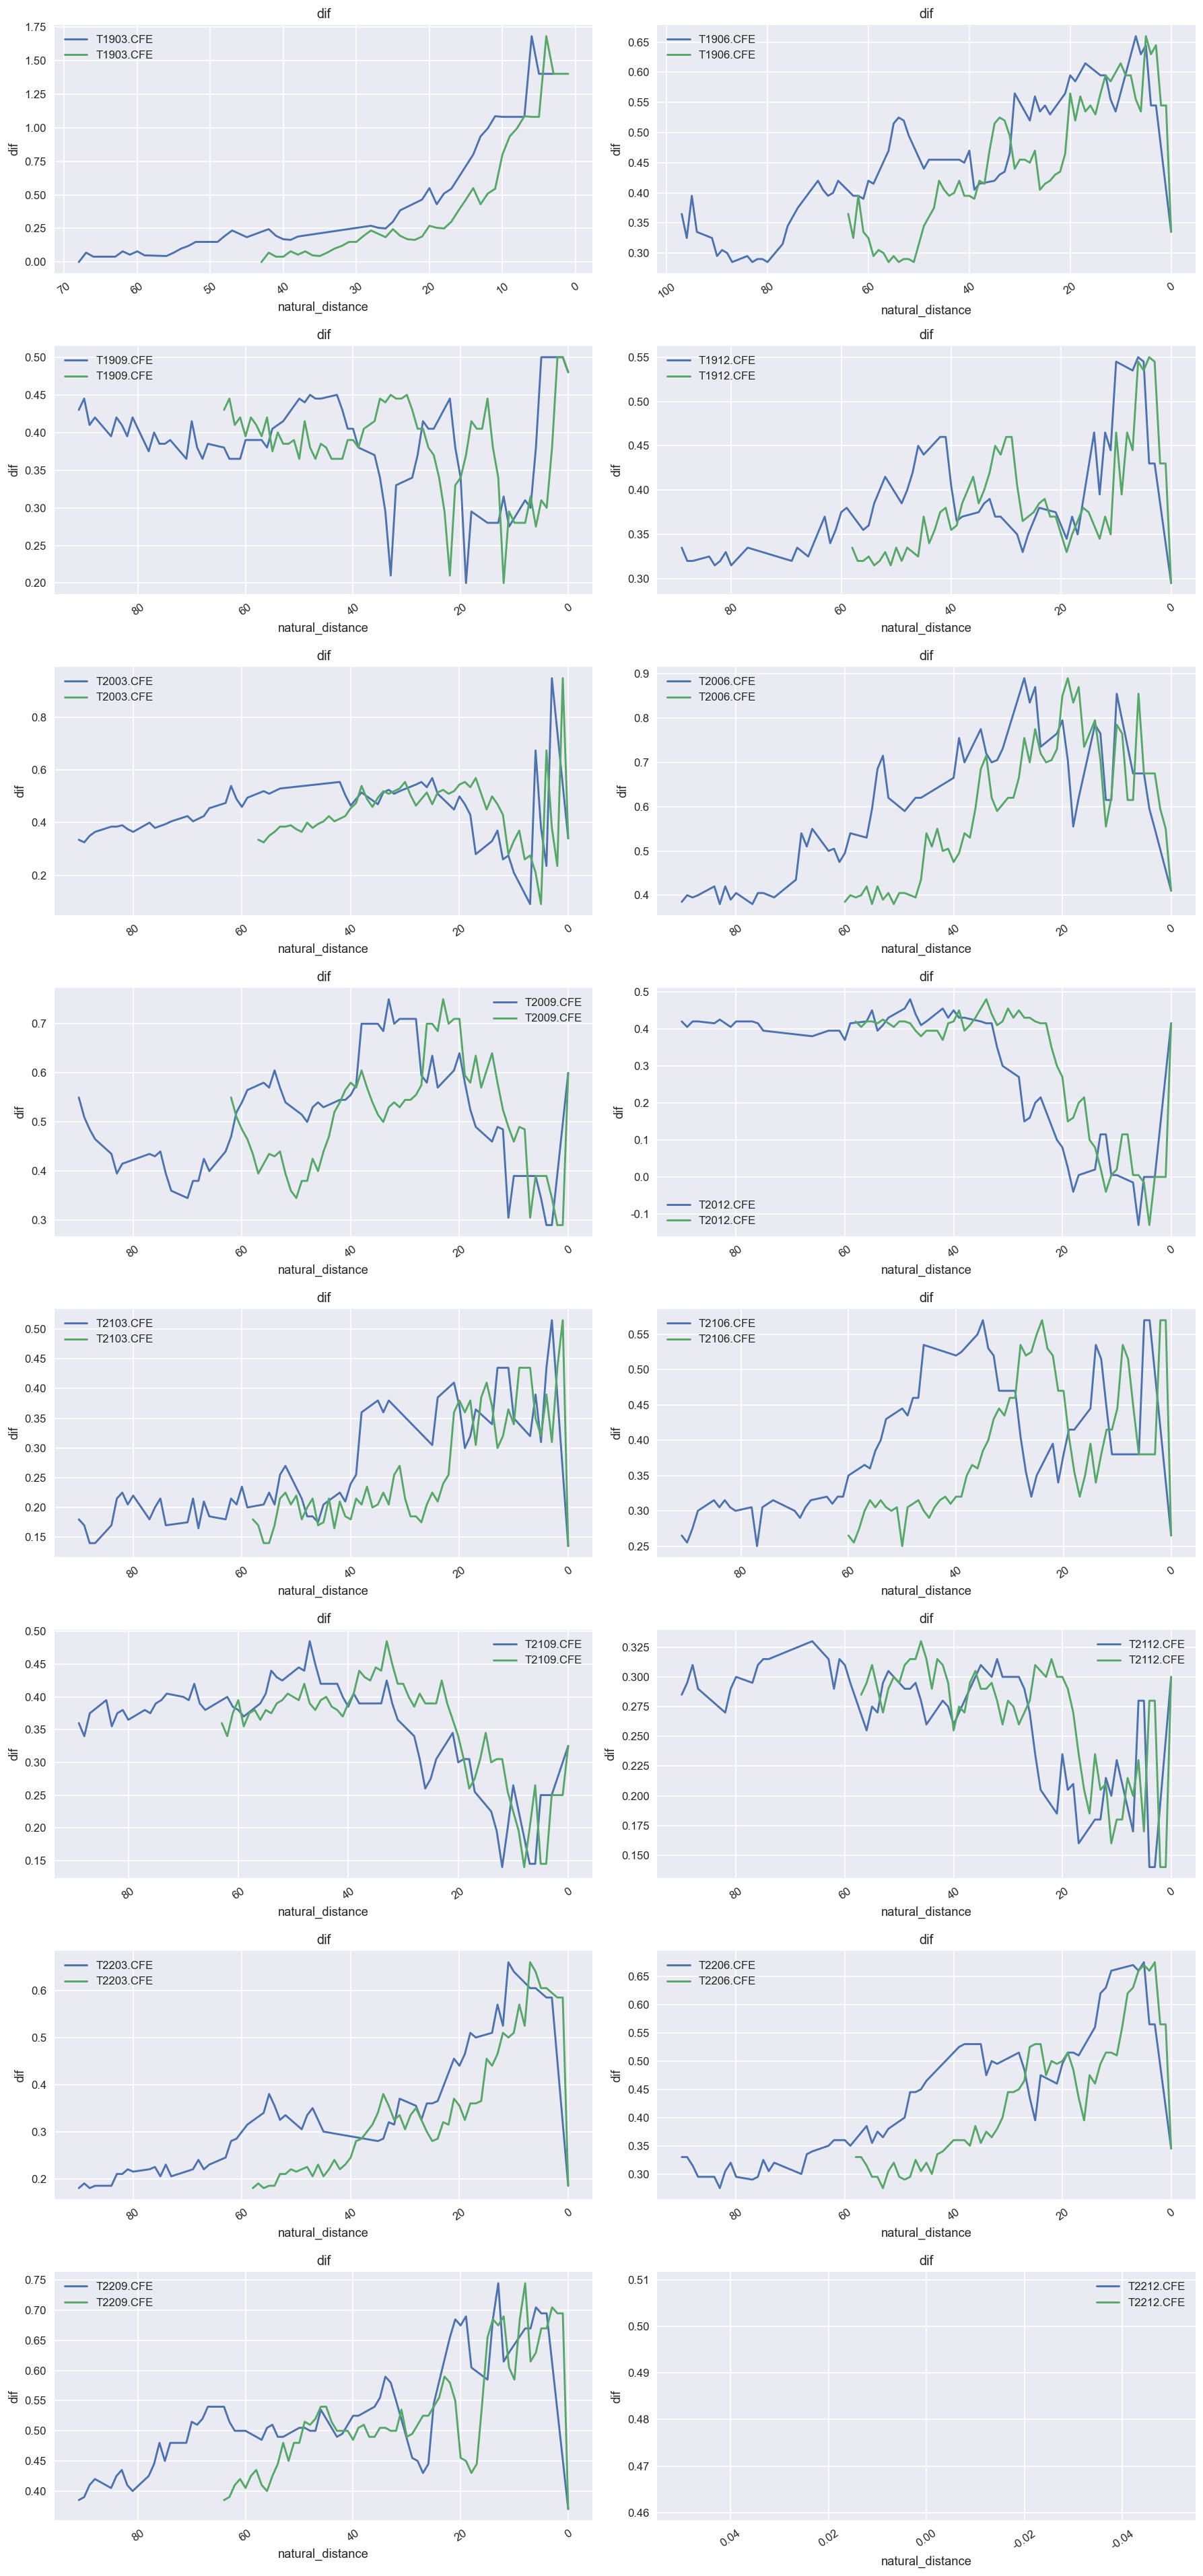

In [116]:
df_date_settle = calendar_effect(dominant_type='date',price_type='settle')

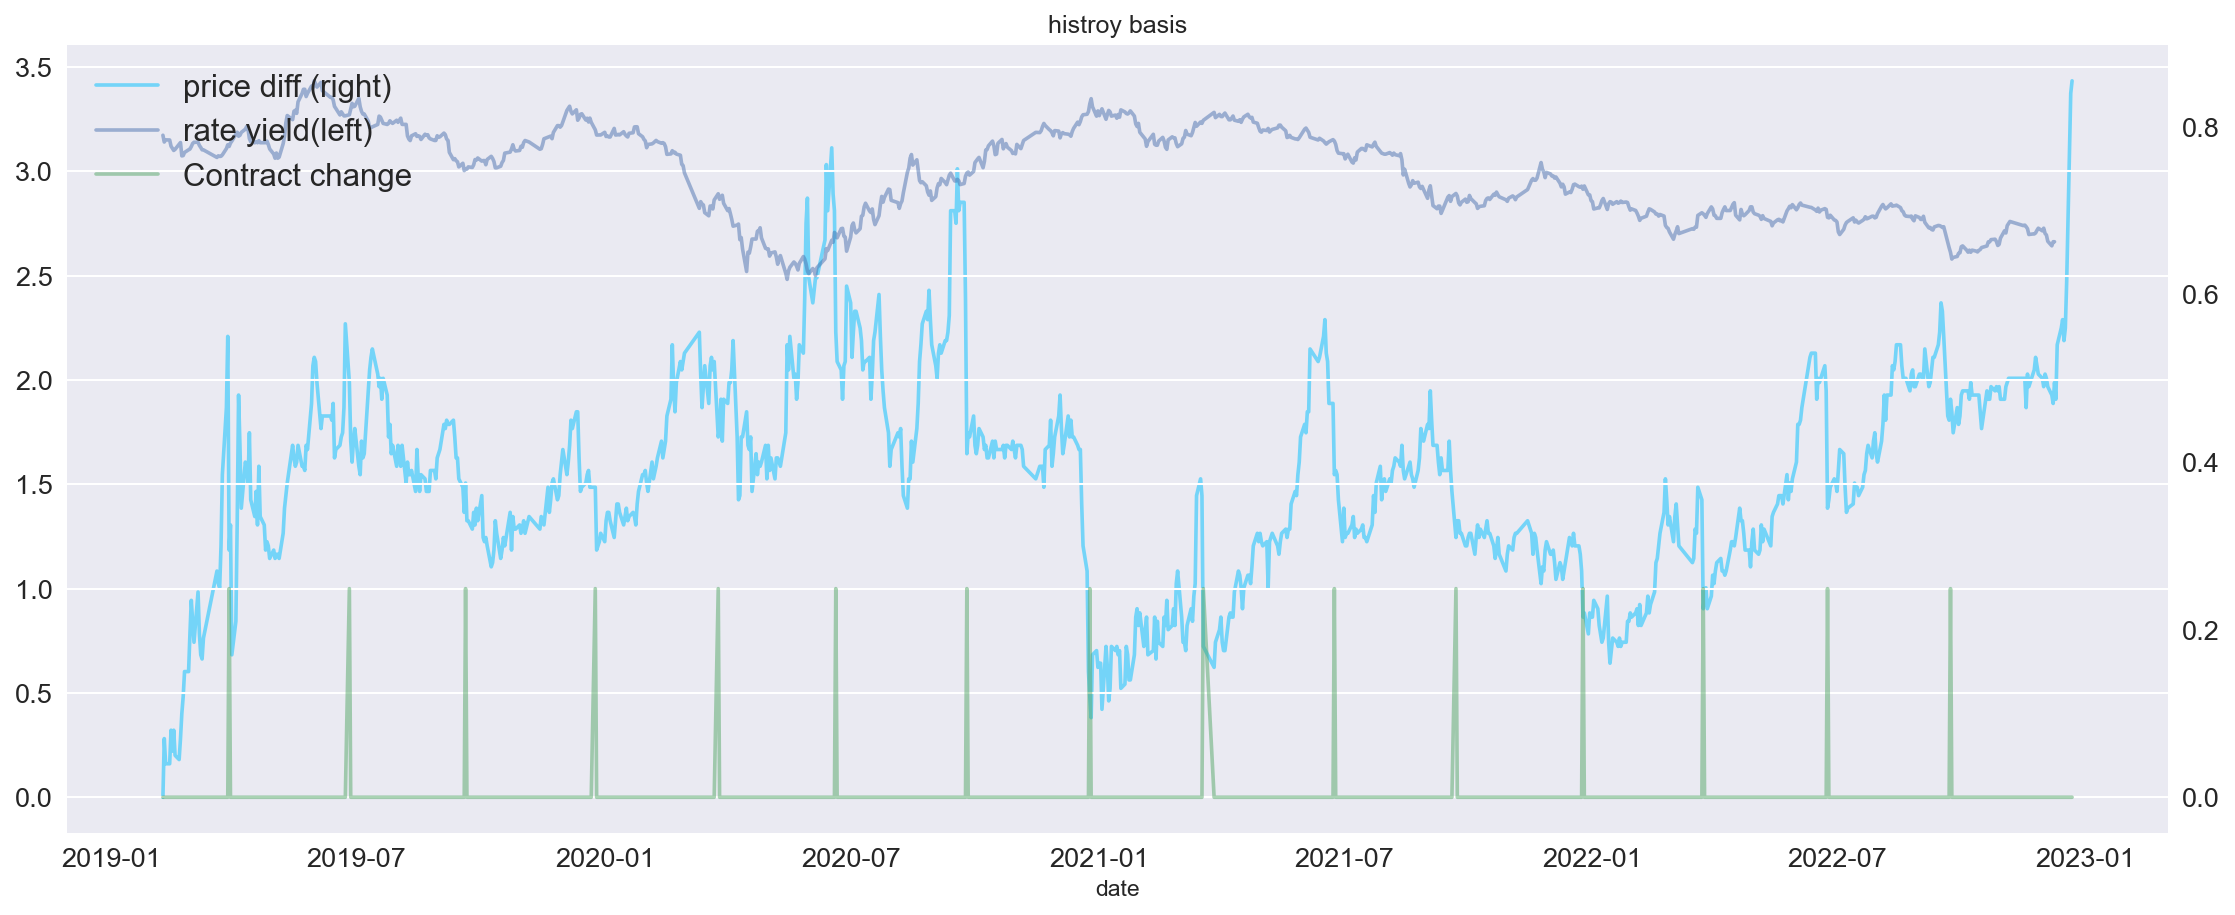

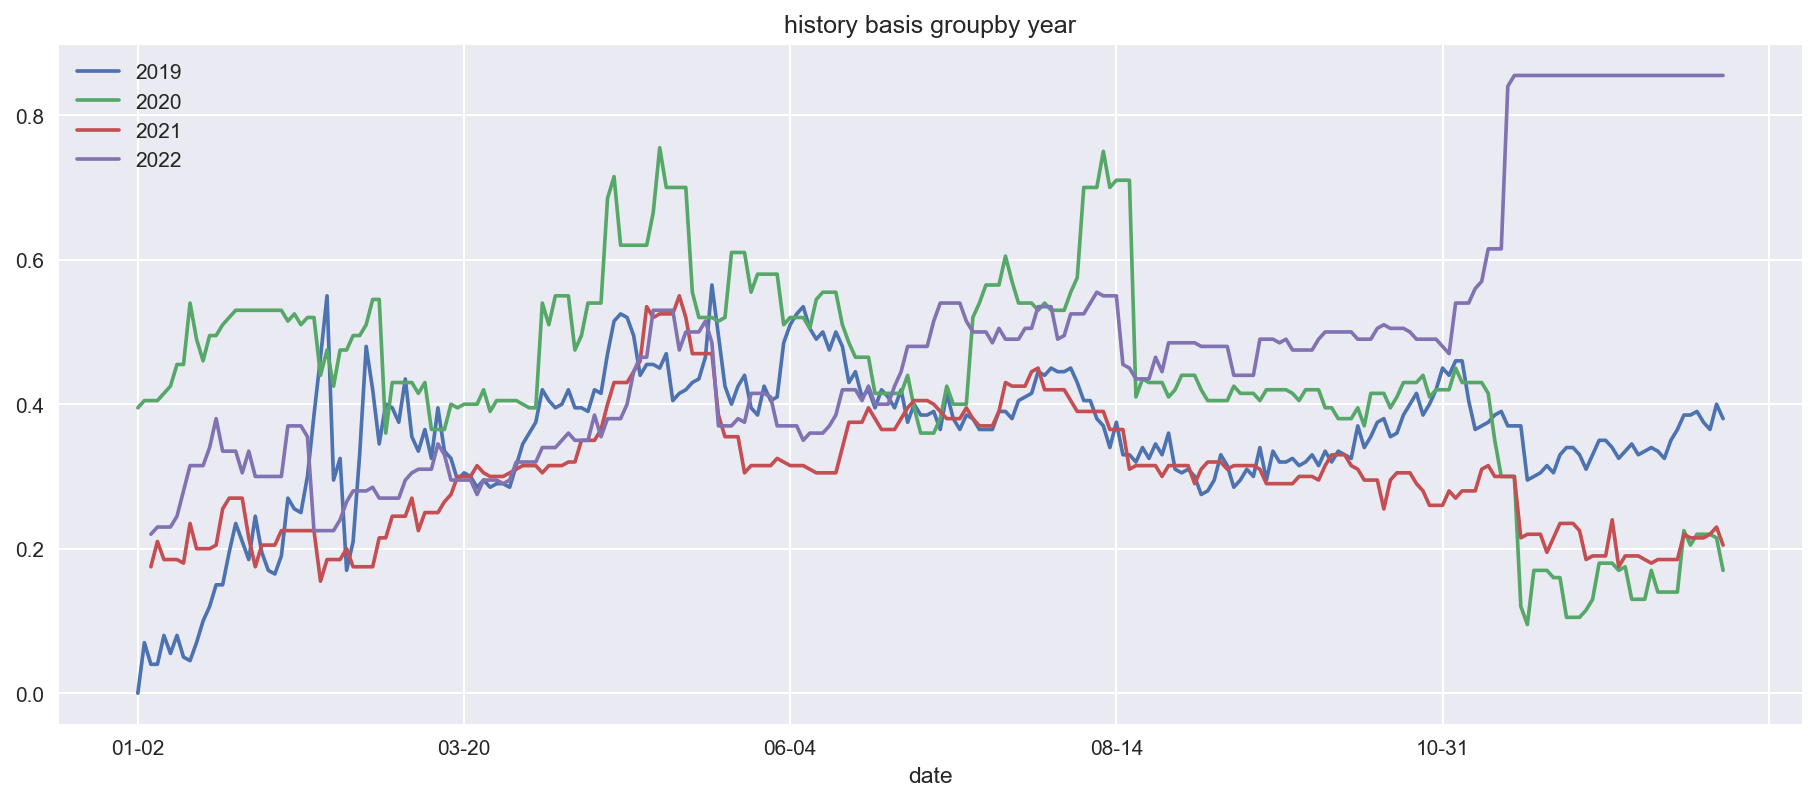

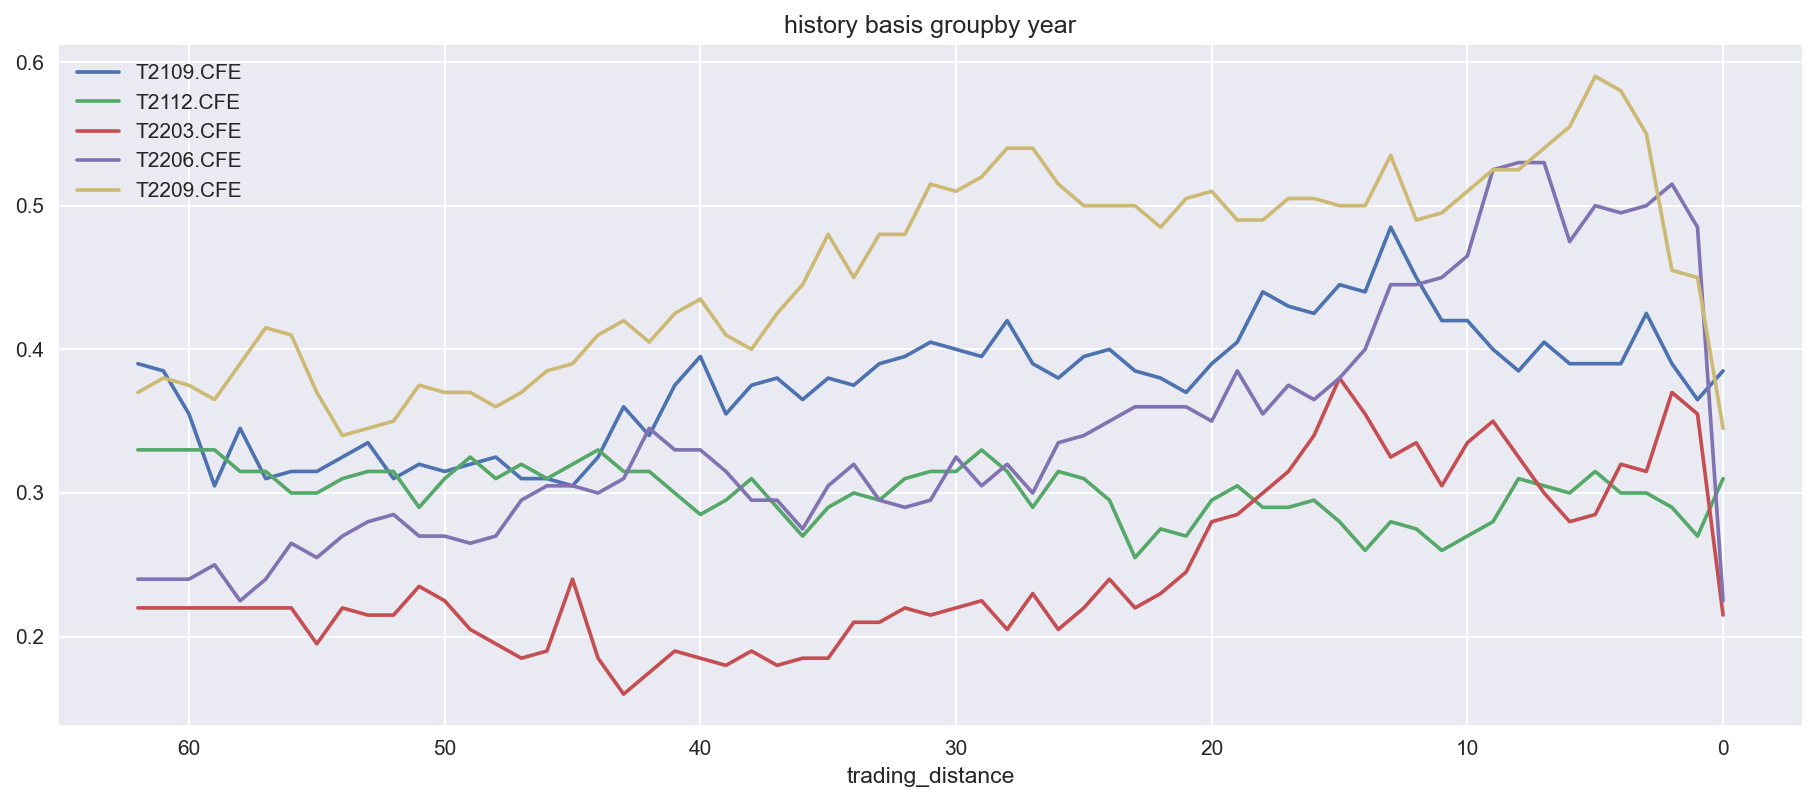

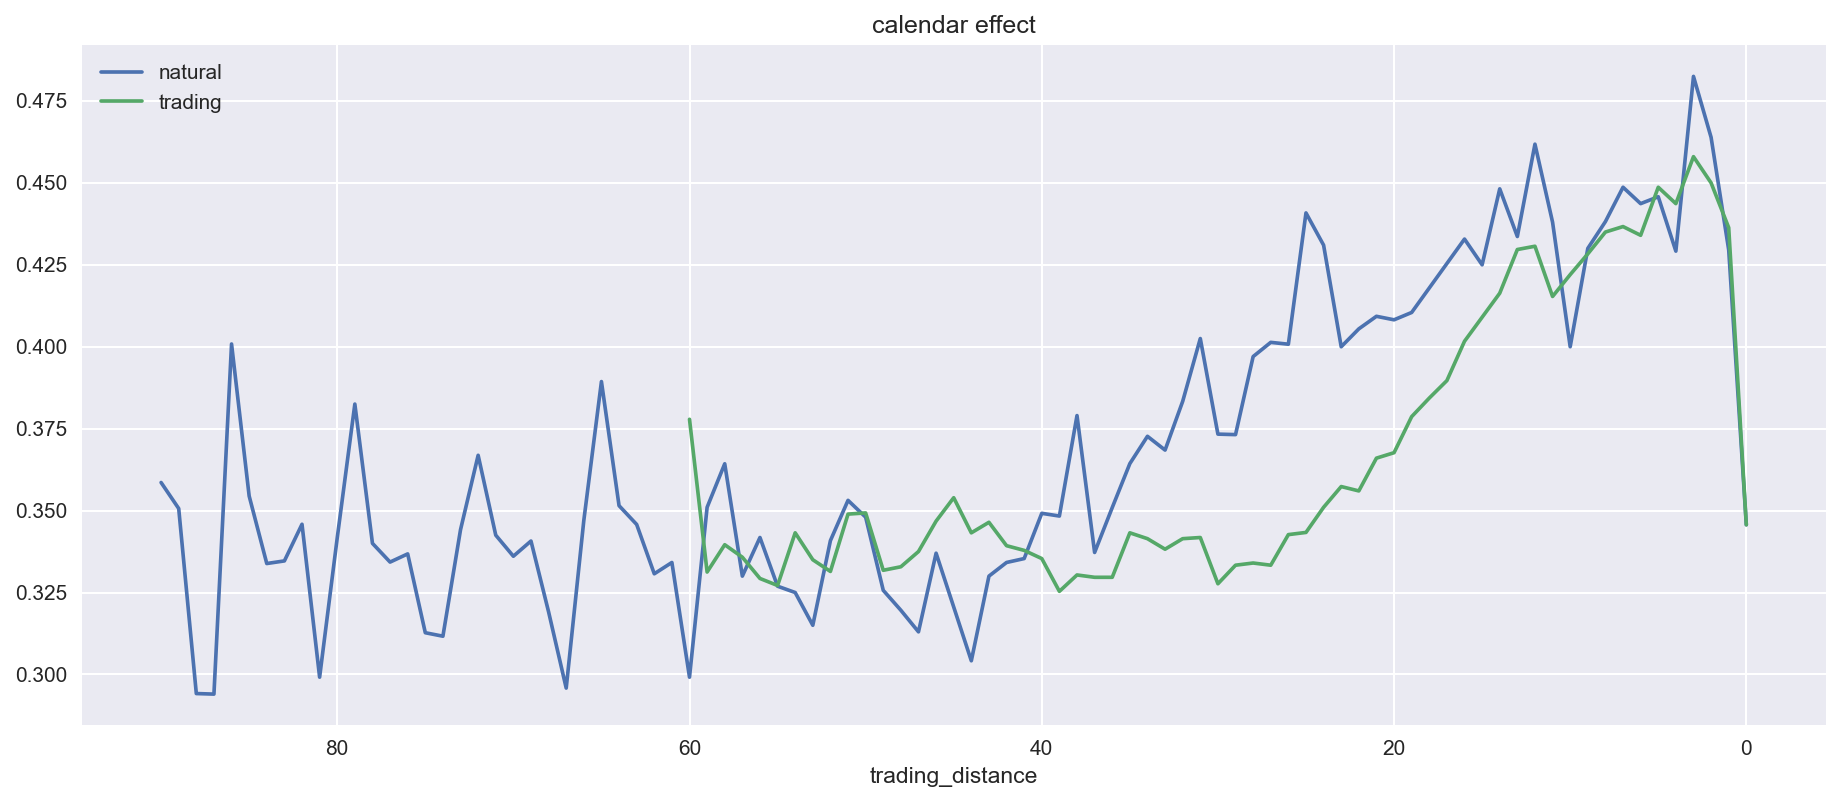

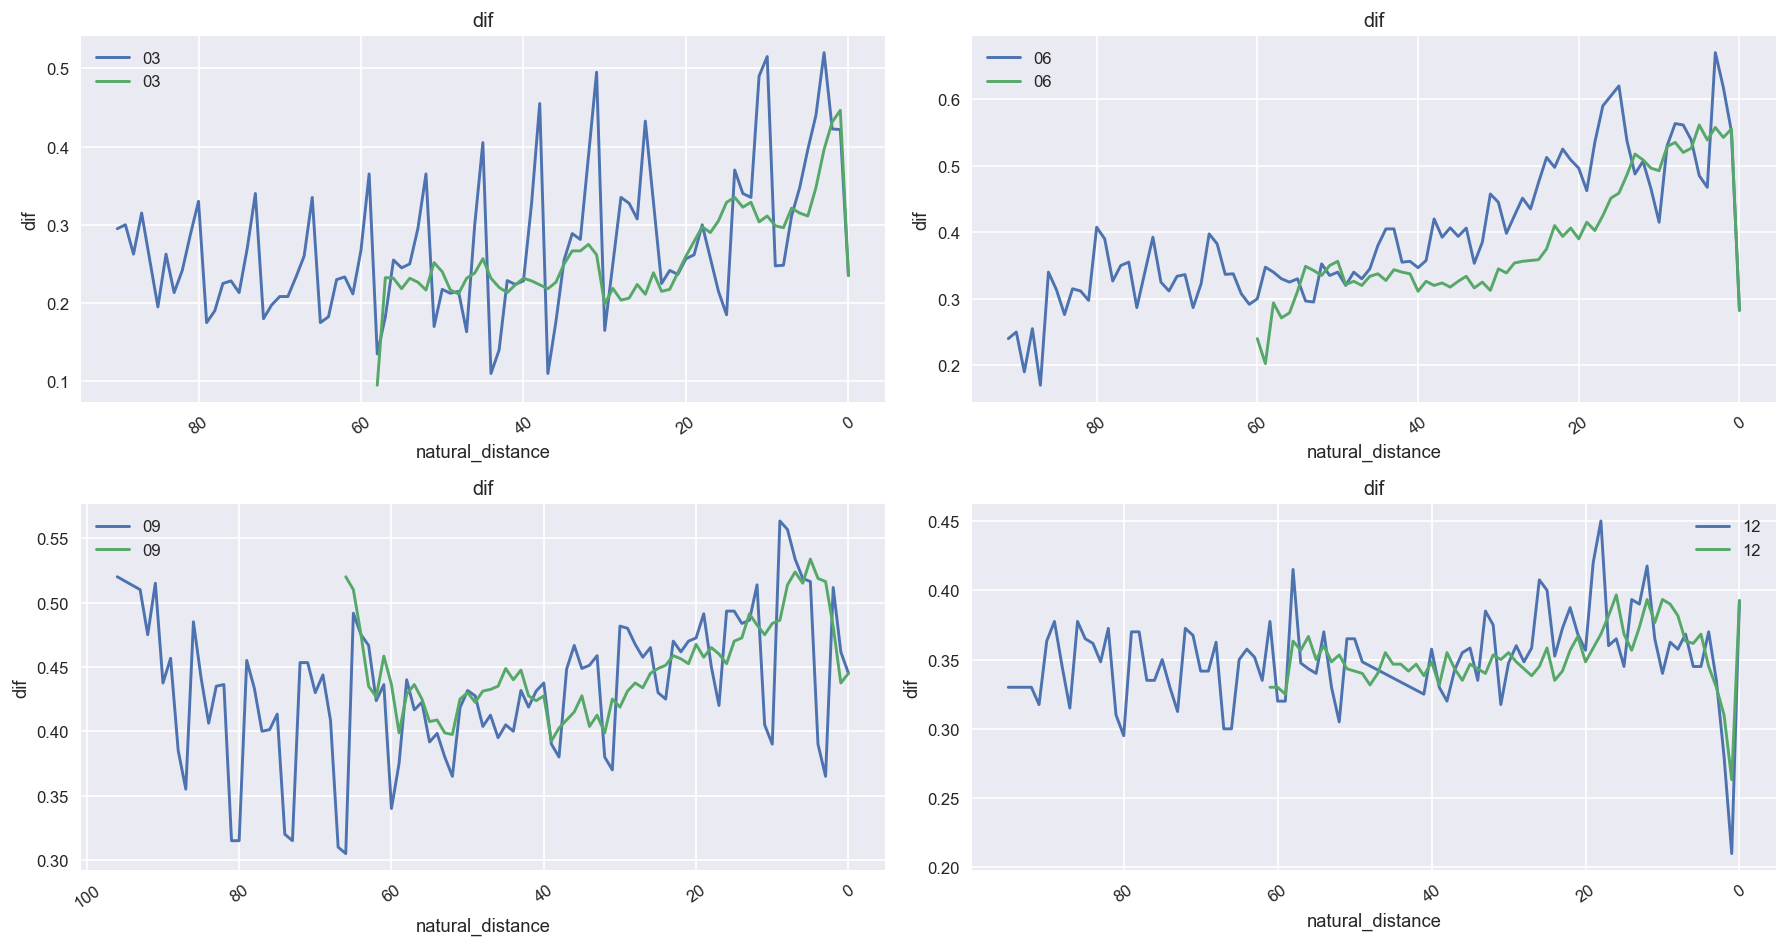

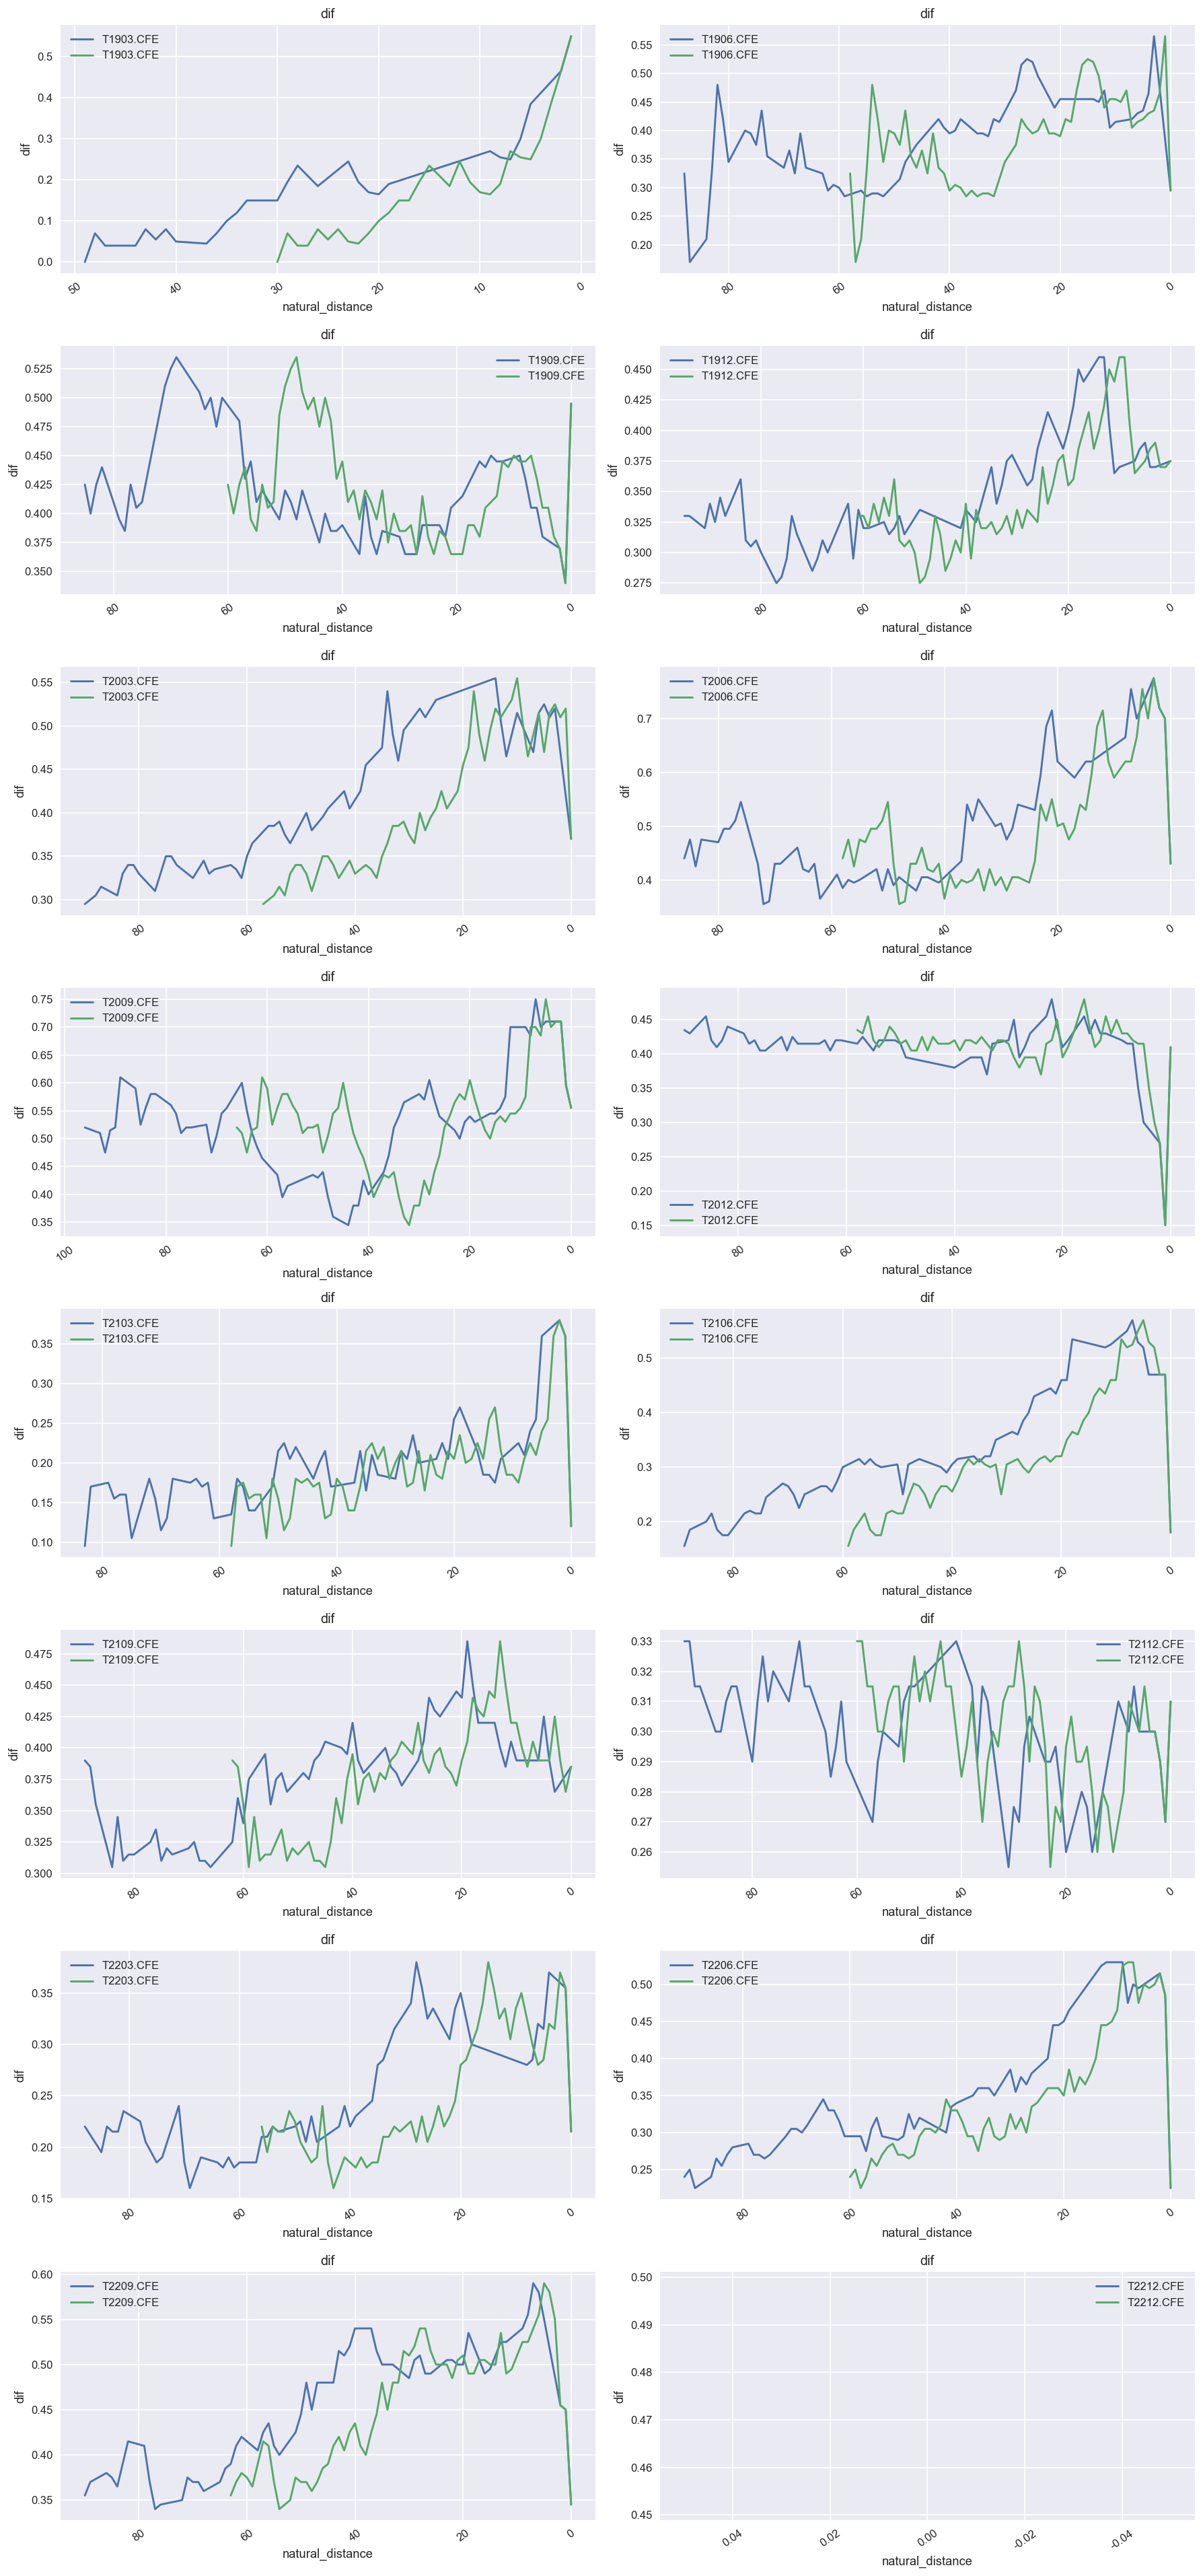

In [117]:
df_oi = calendar_effect()

In [14]:
df_oi.reset_index().groupby('T00.CFE').last()

date    T01.CFE  close_T00.CFE  close_T01.CFE    dif  tag  \
T00.CFE                                                                     
T1803.CFE 2018-02-06  T1806.CFE         92.095         92.155 -0.060    0   
T1806.CFE 2018-05-16  T1809.CFE         94.120         94.130 -0.010    0   
T1809.CFE 2018-08-13  T1812.CFE         95.130         95.085  0.045    0   
T1812.CFE 2018-11-13  T1903.CFE         96.060         96.065 -0.005    0   
T1903.CFE 2019-02-19  T1906.CFE         98.005         97.490  0.515    0   
T1906.CFE 2019-05-17  T1909.CFE         97.440         96.865  0.575    0   
T1909.CFE 2019-08-13  T1912.CFE         99.345         99.020  0.325    0   
T1912.CFE 2019-11-15  T2003.CFE         98.010         97.620  0.390    0   
T2003.CFE 2020-02-14  T2006.CFE        100.390         99.855  0.535    0   
T2006.CFE 2020-05-13  T2009.CFE        101.655        100.945  0.710    0   
T2009.CFE 2020-08-18  T2012.CFE         99.365         98.735  0.630    0   
T2012.CFE 2020-11-17  T2103.CFE         97.515         97.350  0.165    0   
T2103.CFE 2021-02-09  T2106.CFE         97.325         96.985  0.340    0   
T2106.CFE 2021-05-17  T2109.CFE         98.270         97.800  0.470    0   
T2109.CFE 2021-08-13  T2112.CFE         99.895         99.530  0.365    0   
T2112.CFE 2021-11-17  T2203.CFE         99.970         99.700  0.270    0   
T2203.CFE 2022-02-14  T2206.CFE        100.535        100.175  0.360    0   
T2206.CFE 2022-05-17  T2209.CFE        100.655        100.155  0.500    0   
T2209.CFE 2022-08-16  T2212.CFE        101.985        101.530  0.455    0   
T2212.CFE 2022-11-15  T2303.CFE        100.490         99.630  0.860    0   

           natural_distance  trading_distance month  
T00.CFE                                              
T1803.CFE               1.0               1.0    03  
T1806.CFE               1.0               1.0    06  
T1809.CFE               1.0               1.0    09  
T1812.CFE               1.0               1.0    12  
T1903.CFE               1.0               1.0    03  
T1906.CFE               3.0               1.0    06  
T1909.CFE               1.0               1.0    09  
T1912.CFE               3.0               1.0    12  
T2003.CFE               3.0               1.0    03  
T2006.CFE               1.0               1.0    06  
T2009.CFE               1.0               1.0    09  
T2012.CFE               1.0               1.0    12  
T2103.CFE               1.0               1.0    03  
T2106.CFE               1.0               1.0    06  
T2109.CFE               3.0               1.0    09  
T2112.CFE               1.0               1.0    12  
T2203.CFE               1.0               1.0    03  
T2206.CFE               1.0               1.0    06  
T2209.CFE               1.0               1.0    09  
T2212.CFE               0.0               0.0    12

<AxesSubplot:xlabel='date'>

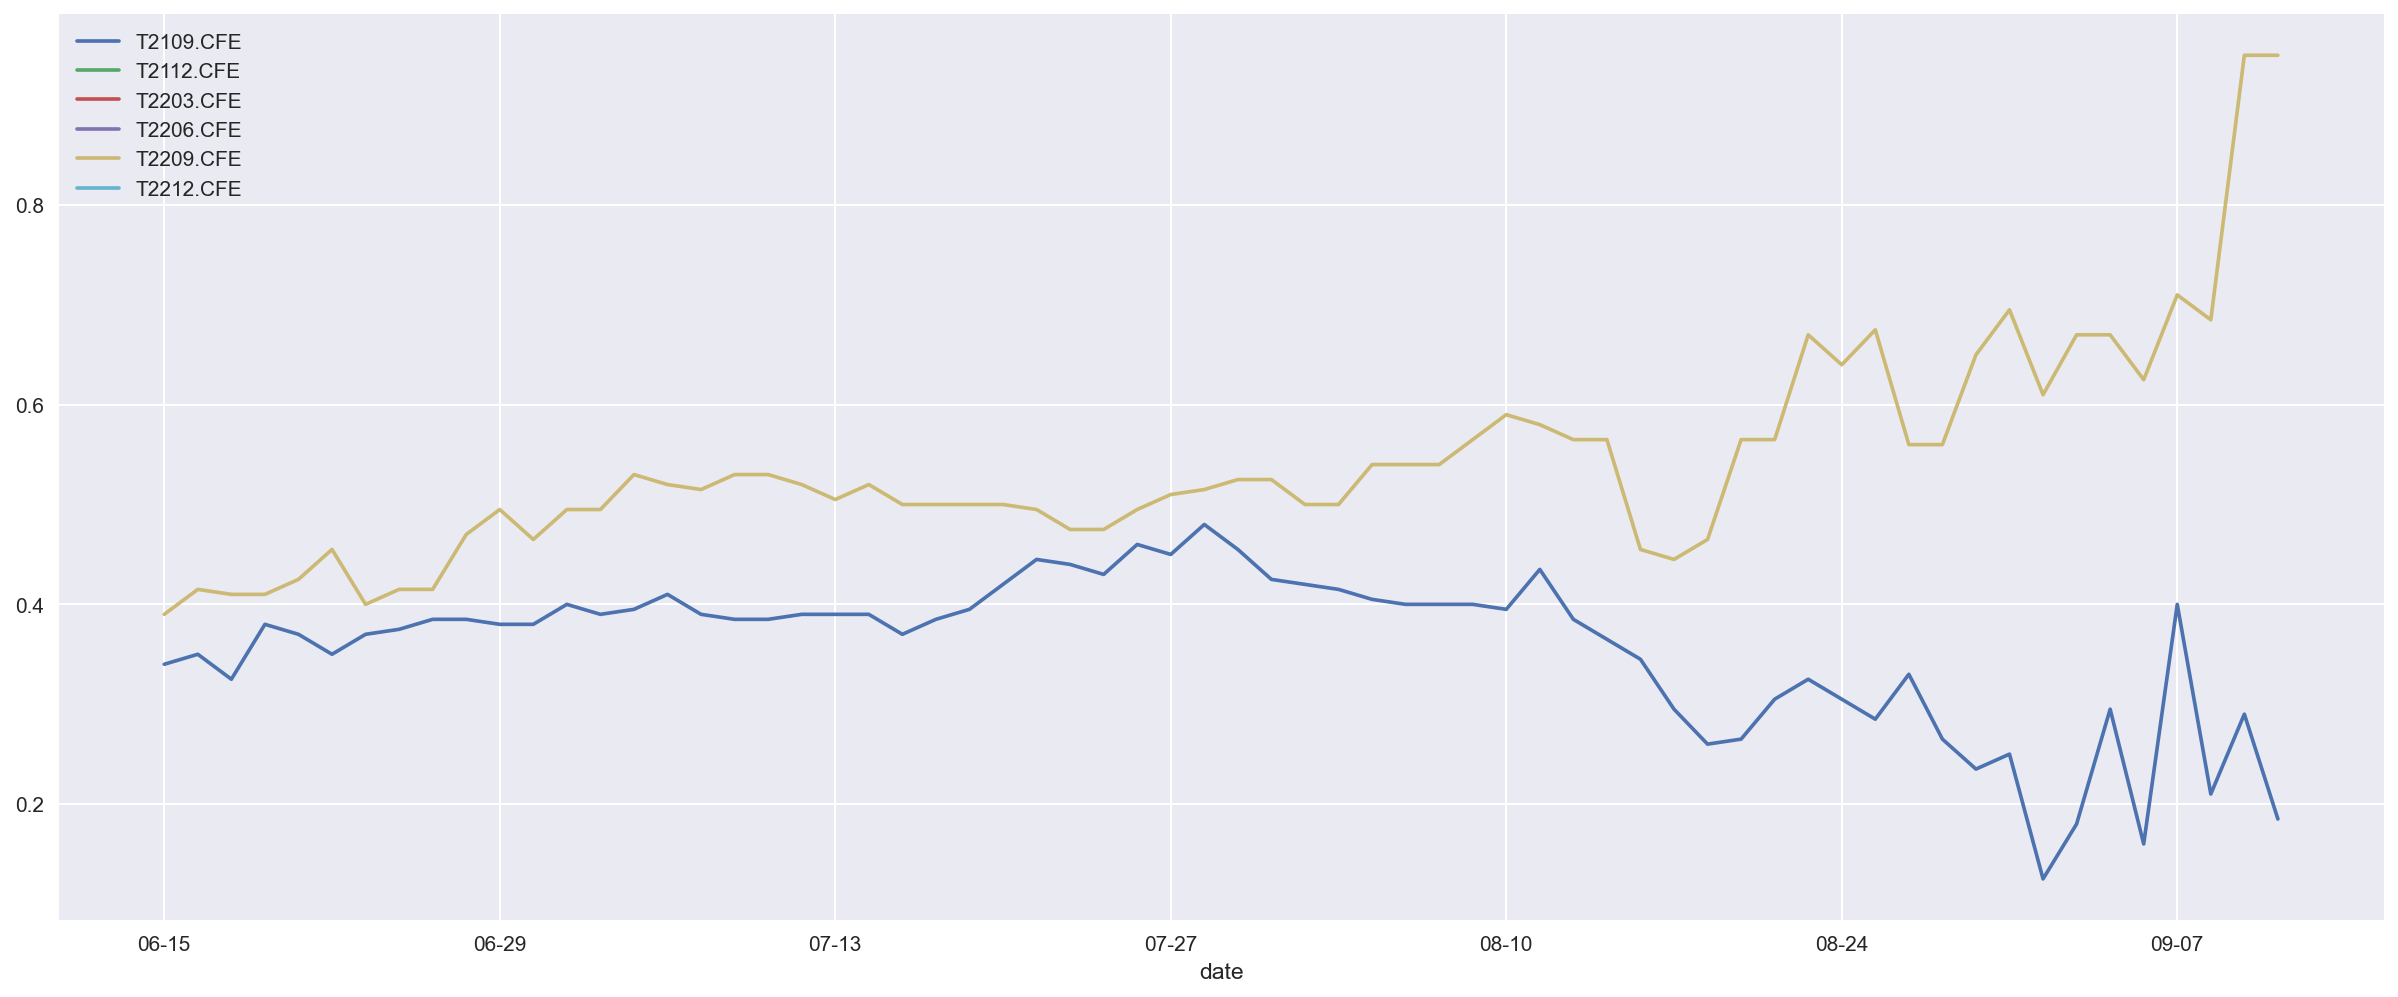

In [4]:
# # wind 主力切换时间是上一个主力到期后
# df = w.wsd('T00.CFE', "trade_hiscode,settle,close", "2015-03-20", "2022-11-26", "",usedf=True)[1]
# df.reset_index().groupby('TRADE_HISCODE').first()

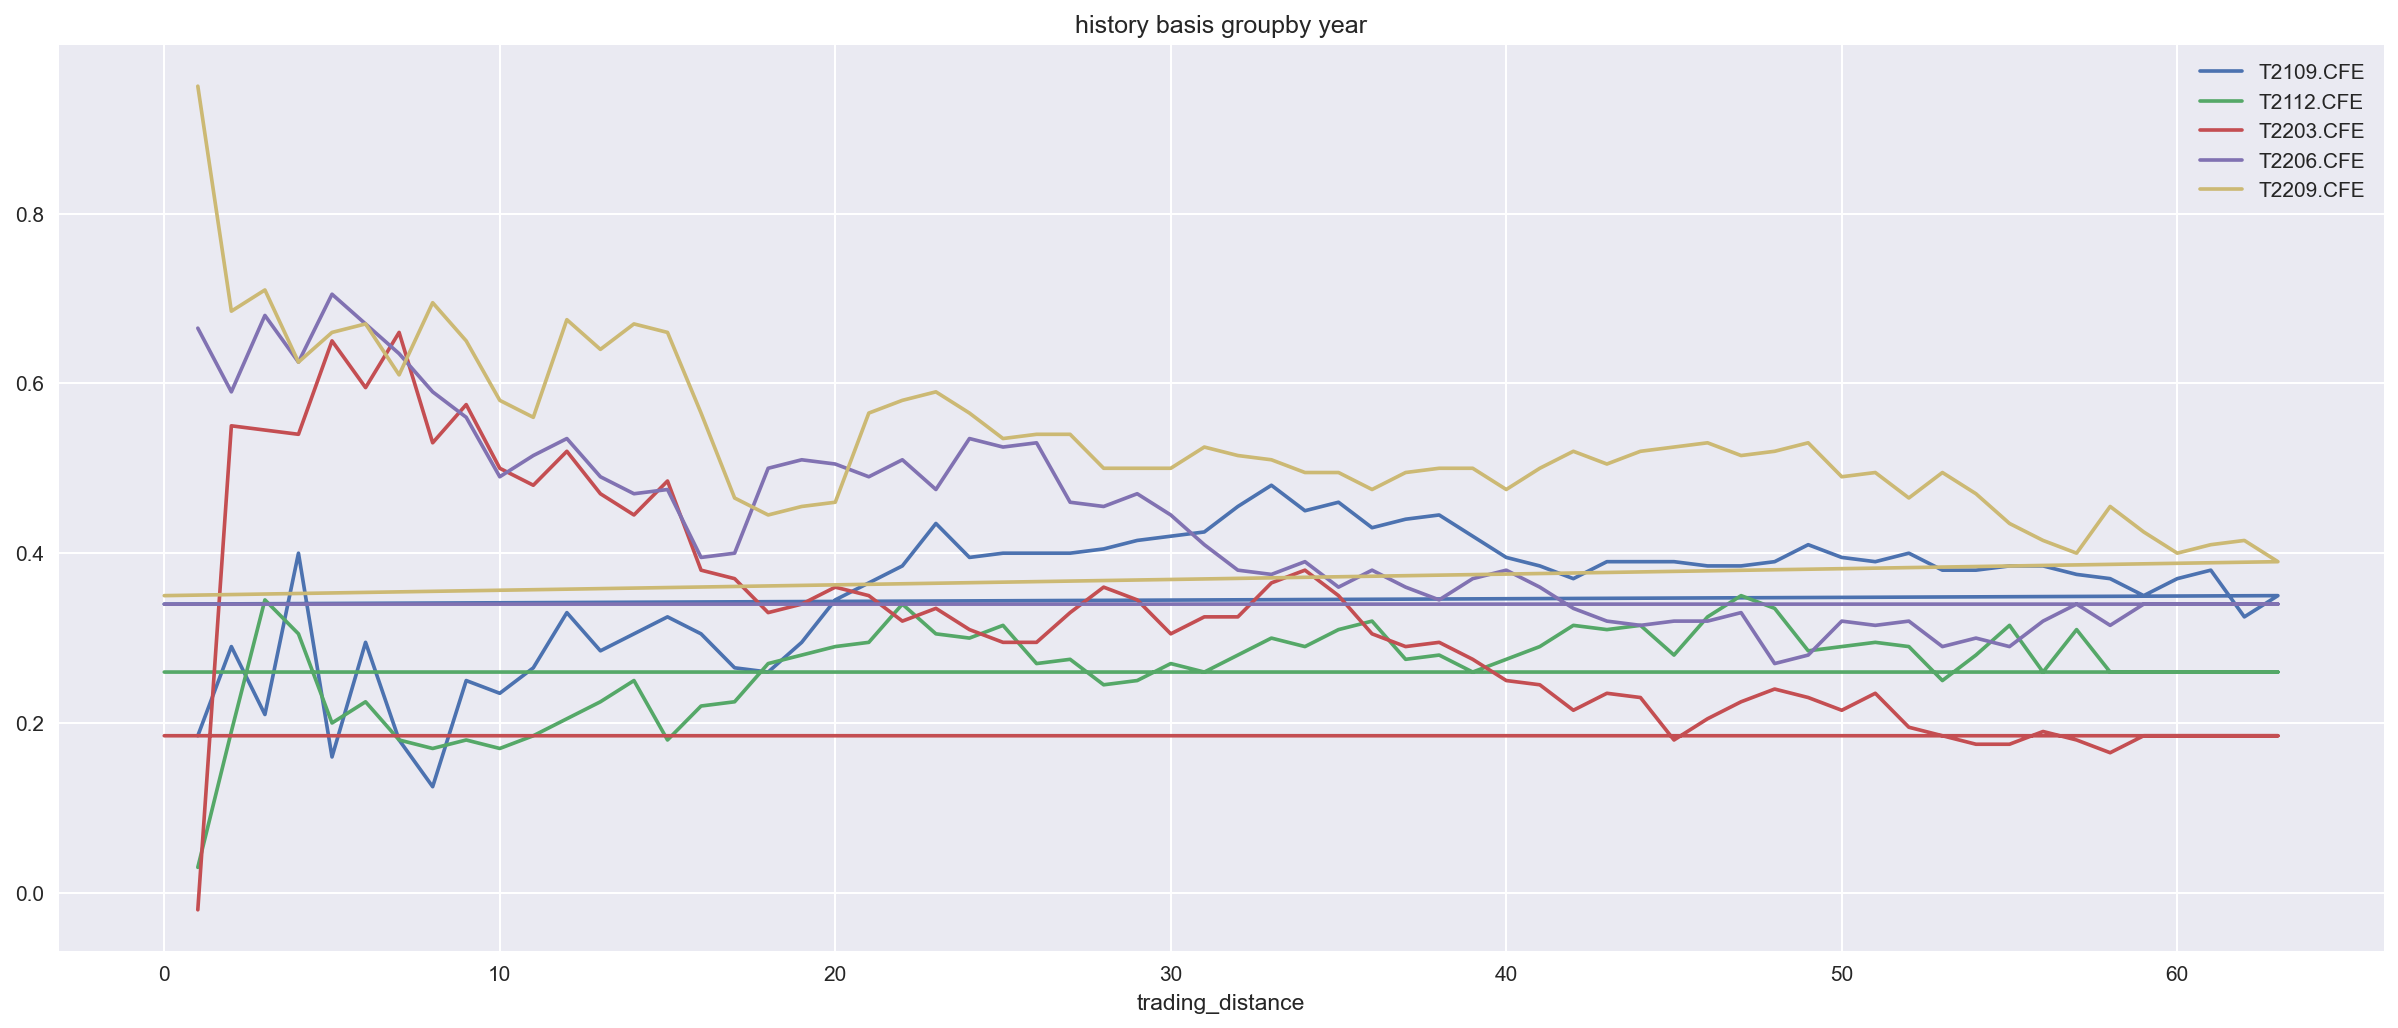

In [64]:
    code_data_contract=pd.DataFrame()
    code_list = list(df_date['T00.CFE'].unique())
    code_list.sort()
    for x in code_list[-6:-1]:
        code_data_contract[x]=df_date.loc[df_date['T00.CFE']==x].set_index('trading_distance')['dif']
    code_data_contract.ffill().plot(figsize=(20, 8))
    plt.legend()
    plt.title('history basis groupby year')
    plt.show()

In [144]:
signal1 =pd.concat([df_date_close.reset_index().groupby('T00.CFE').tail(3).groupby('T00.CFE').first().assign(weight=0.5)[['last_day']].assign(weight=-0.5).reset_index().set_index('last_day').rename(columns={'T00.CFE':"sec_code"}),
                df_date_close.reset_index().groupby('T00.CFE').tail(3).groupby('T01.CFE').first().assign(weight=0.5)[['last_day']].assign(weight=0.5).reset_index().set_index('last_day').rename(columns={'T01.CFE':"sec_code"})],
                axis=0).reset_index().rename(columns={'last_day':'trade_date'})
signal2=pd.concat([df_date_close.reset_index().groupby('T00.CFE')[['last_day']].last().assign(weight=0).reset_index().set_index('last_day').rename(columns={'T00.CFE':"sec_code"}),
df_date_close.reset_index().groupby('T01.CFE')[['last_day']].last().assign(weight=0).reset_index().set_index('last_day').rename(columns={'T01.CFE':"sec_code"}),
],axis=0).reset_index().rename(columns={'last_day':'trade_date'})
signal = pd.concat([signal1,signal2],axis=0).sort_values('trade_date')
signal.reset_index(drop=True).to_csv('./input/signal/diff.csv')